In [1]:
!pip install fedartml
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 12.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.


In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from io import BytesIO
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import SGD

from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()

import time
import pickle

import pandas as pd

import matplotlib.pyplot as plt

# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

from fedartml import InteractivePlots, SplitAsFederatedData

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
from scipy.stats import cramervonmises

from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics

In [3]:
# Define function to test a model and retrieve classification metrics
def test_model(model, X_test, Y_test):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
    logits = model.predict(X_test, batch_size=16, verbose=0, callbacks=[GarbageCollectorCallback()])
    y_pred = tf.argmax(logits, axis=1)
    loss = cce(Y_test, logits).numpy()
    acc = accuracy_score(y_pred, Y_test)
    pre = precision_score(y_pred, Y_test, average='weighted',zero_division = 0)
    rec = recall_score(y_pred, Y_test, average='weighted',zero_division = 0)
    f1s = f1_score(y_pred, Y_test, average='weighted',zero_division = 0)

    return loss, acc, pre, rec, f1s

# Define function to convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
def from_FedArtML_to_Flower_format(clients_dict):
  # initialize list that contains clients (features and labels) to extract later from client_fn in Flower
  list_x_train = []
  list_y_train = []

  # Get the name of the clients from the dictionary
  client_names = list(clients_dict.keys())

  # Iterate over each client
  for client in client_names:
    # Get data from each client
    each_client_train=np.array(clients_dict[client],dtype=object)

    # Extract features for each client
    feat=[]
    x_tra=np.array(each_client_train[:, 0])
    for row in x_tra:
      feat.append(row)
    feat=np.array(feat)

    # Extract labels from each client
    y_tra=np.array(each_client_train[:, 1])

    # Append in list features and labels to extract later from client_fn in Flower
    list_x_train.append(feat)
    list_y_train.append(y_tra)

  return list_x_train, list_y_train

def get_model():
    """Constructs a simple model architecture suitable for MNIST."""
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ]
    )
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Define local training/evaluation function
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test, epochs_client) -> None:
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.epochs_client = epochs_client

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, validation_split=0.1, epochs=self.epochs_client, verbose=0, batch_size = 16, callbacks=[GarbageCollectorCallback()])
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}


def plot_metric_from_history(
    hist: None,
    save_plot_path: None,
    metric_type: None,
    metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    save_plot_path : Path
        Folder to save the plot to.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to plot.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to plot.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    # plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
    plt.plot(np.asarray(rounds), np.asarray(values), color=colors[5], linewidth=5, label='Test')
    plt.legend(fontsize=45)
    plt.xlabel('Communication round', fontsize=40)
    plt.ylabel(metric, fontsize=50)
    plt.title(metric, fontsize=60)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    # plt.ylim(min(min(min(commun_metrics))) - 0.05, max(max(max(commun_metrics))) + 0.05)
    plt.ylim(0, 1)
    # plt.savefig(Path(save_plot_path) / Path(f"{metric_type}_metrics{suffix}.png"))
    # plt.close()

def retrieve_global_metrics(
    hist: None,
    metric_type: None,
    metric: None,
    best_metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to retrieve.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to retrieve.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    if best_metric:
      metric_return = max(values)
    else:
      metric_return = values[-1]
    return metric_return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
from flwr.server.client_manager import ClientManager
import threading
from abc import ABC, abstractmethod
from logging import INFO
from typing import Dict, List, Optional
import random
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion

class SimpleClientManager(ClientManager):
    def __init__(self) -> None:
        self.clients: Dict[str, ClientProxy] = {}
        self._cv = threading.Condition()
        self.seed = 0

    def __len__(self) -> int:
        return len(self.clients)

    def num_available(self) -> int:
        return len(self)

    def wait_for(self, num_clients: int, timeout: int = 86400) -> bool:
        with self._cv:
            return self._cv.wait_for(
                lambda: len(self.clients) >= num_clients, timeout=timeout
            )

    def register(self, client: ClientProxy) -> bool:
        if client.cid in self.clients:
            return False

        self.clients[client.cid] = client
        with self._cv:
            self._cv.notify_all()

        return True

    def unregister(self, client: ClientProxy) -> None:
        if client.cid in self.clients:
            del self.clients[client.cid]

            with self._cv:
                self._cv.notify_all()

    def all(self) -> Dict[str, ClientProxy]:
        return self.clients

    def sample(
        self,
        num_clients: int,
        min_num_clients: Optional[int] = None,
        criterion: Optional[Criterion] = None,
    ) -> List[ClientProxy]:
        """Sample a number of Flower ClientProxy instances."""
        # Block until at least num_clients are connected.
        random.seed(self.seed)
        self.seed += 1
        if min_num_clients is None:
            min_num_clients = num_clients
        self.wait_for(min_num_clients)
        # Sample clients which meet the criterion
        available_cids = list(self.clients)
        if criterion is not None:
            available_cids = [
                cid for cid in available_cids if criterion.select(self.clients[cid])
            ]

        sampled_cids = random.sample(available_cids, num_clients)
        #print(sampled_cids)
        return [self.clients[cid] for cid in sampled_cids]

In [12]:
# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue","#FFFFFF"]

# Define number of local nodes to be used
local_nodes_glob = 20

# Define percentage of noniid to be used
Percent_noniid = 1000

Alpha = 0.1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical

# Define random state for reproducibility
random_state = 0

# Tải dữ liệu MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
# Instantiate a SplitAsFederatedData object
my_federater = SplitAsFederatedData(random_state = random_state)

# Get federated dataset from centralized dataset
clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances = my_federater.create_clients(image_list = train_images, label_list = train_labels,
                                                             num_clients = local_nodes_glob, prefix_cli='client', method = "dirichlet", alpha = Alpha)

clients_glob = clients_glob_dic['with_class_completion']
list_ids_sampled = list_ids_sampled_dic['with_class_completion']

list_x_train, list_y_train = from_FedArtML_to_Flower_format(clients_dict=clients_glob)


In [7]:
# The `evaluate` function will be by Flower called after every round
def evaluate_DNN_CL(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = get_model()
    net.set_weights(parameters) # Update model with the latest parameters
    loss, accuracy, precision, recall, f1score  = test_model(net, test_images, test_labels)
    print(f"@@@@@@ Server-side evaluation loss {loss} / accuracy {accuracy} @@@@@@")
    return loss, {"accuracy": accuracy,"precision": precision,"recall": recall,"f1score": f1score}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
from flwr.common import (
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

# Define number of epochs per local node
epochs = 1

# Define number of communication rounds
comms_round = 100
seed_value = 42
tf.random.set_seed(seed_value)
initial_model = get_model()

# Define dunction to pass to each local node (client)
def client_fn(cid: str) -> fl.client.Client:
    # Define model
    seed_value = 42
    tf.random.set_seed(seed_value)
    model = get_model()

    # Load data partition of each client ID (cid)
    x_train_cid = np.array(list_x_train[int(cid)],dtype=float)
    y_train_cid = np.array(list_y_train[int(cid)],dtype=float)

    # Define test data (taken from the centralized data to compare performance of CL and FL)
    x_test_cid = np.array(test_images)
    y_test_cid = np.array(test_labels)

    # Create and return client
    return FlowerClient(model, x_train_cid, y_train_cid, x_test_cid, y_test_cid, epochs)

# Create Federated strategy
strategy= fl.server.strategy.FedAdam(
        fraction_fit=0.3,  # Sample 100% of available clients for training
        fraction_evaluate=0.05,  # Sample 50% of available clients for evaluation
        min_fit_clients=6,
        min_evaluate_clients = 1,
        min_available_clients = 20,
        evaluate_fn=evaluate_DNN_CL,
        initial_parameters  = ndarrays_to_parameters(initial_model.get_weights())
)
client_manager = SimpleClientManager()

start_time = time.time()
# Start simulation (training FL)
commun_metrics_history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=local_nodes_glob,
    config=fl.server.ServerConfig(num_rounds=comms_round),
    strategy=strategy,
)

# Get total training time
training_time = time.time() - start_time

# Unmask metrics
global_acc_test = retrieve_global_metrics(commun_metrics_history,"centralized","accuracy",True)

global_pre_test = retrieve_global_metrics(commun_metrics_history,"centralized","precision",True)

global_rec_test = retrieve_global_metrics(commun_metrics_history,"centralized","recall",True)

global_f1s_test = retrieve_global_metrics(commun_metrics_history,"centralized","f1score",True)

print("\n\nFINAL RESULTS: ===========================================================================================================================================================================================")
print('Test: commun_round: {} | global_acc: {:} | global_pre: {} | global_rec: {} | global_f1s: {}'.format(comms_round, global_acc_test, global_pre_test, global_rec_test, global_f1s_test))
print("Training time: %s seconds" % (training_time))

INFO flwr 2024-02-24 13:42:21,712 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2024-02-24 13:42:28,928	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-24 13:42:31,206 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3949000704.0, 'memory': 7898001408.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3949000704.0, 'memory': 7898001408.0}
INFO flwr 2024-02-24 13:42:31,215 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-24

625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:42:37,095 | server.py:94 | initial parameters (loss, other metrics): 2.2993584, {'accuracy': 0.1423, 'precision': 0.9273121267430133, 'recall': 0.1423, 'f1score': 0.21225944505170533}
INFO:flwr:initial parameters (loss, other metrics): 2.2993584, {'accuracy': 0.1423, 'precision': 0.9273121267430133, 'recall': 0.1423, 'f1score': 0.21225944505170533}
INFO flwr 2024-02-24 13:42:37,099 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2024-02-24 13:42:37,103 | server.py:222 | fit_round 1: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 1: strategy sampled 6 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.299358367919922 / accuracy 0.1423 / f1score 0.21225944505170533 @@@@@@


(DefaultActor pid=432591) /usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=432591)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=432590) 22/22 - 3s - loss: 1.0921 - accuracy: 0.8023 - val_loss: 1.9927 - val_accuracy: 0.7692 - 3s/epoch - 119ms/step
(DefaultActor pid=432590) 196/196 - 7s - loss: 0.2955 - accuracy: 0.9136 - val_loss: 0.2815 - val_accuracy: 0.9398 - 7s/epoch - 35ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 13:43:02,247 | server.py:236 | fit_round 1 received 6 results and 0 failures
DEBUG:flwr:fit_round 1 received 6 results and 0 failures
WARNING flwr 2024-02-24 13:43:02,261 | fedavg.py:250 | No fit_metrics_aggregation_fn provided


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:43:04,659 | server.py:125 | fit progress: (1, 13.573482, {'accuracy': 0.1563, 'precision': 0.9707665306122449, 'recall': 0.1563, 'f1score': 0.23236785936919513}, 27.555467079000664)
INFO:flwr:fit progress: (1, 13.573482, {'accuracy': 0.1563, 'precision': 0.9707665306122449, 'recall': 0.1563, 'f1score': 0.23236785936919513}, 27.555467079000664)
DEBUG flwr 2024-02-24 13:43:04,664 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 13.573481559753418 / accuracy 0.1563 / f1score 0.23236785936919513 @@@@@@


DEBUG flwr 2024-02-24 13:43:06,791 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
WARNING flwr 2024-02-24 13:43:06,794 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-24 13:43:06,799 | server.py:222 | fit_round 2: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 2: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 1109.0013 - accuracy: 0.1563 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 337/337 - 4s - loss: 0.3059 - accuracy: 0.9291 - val_loss: 0.1460 - val_accuracy: 0.9683 - 4s/epoch - 12ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 27/27 - 3s - loss: 235.5065 - accuracy: 0.5000 - val_loss: 39.0607 - val_accuracy: 0.4255 - 3s/epoch - 99ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 91/91 - 3s - loss: 184.0491 - accuracy: 0.5306 - val_loss: 2.4114 - val_accuracy: 0.8580 - 3s/epoch - 38ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:43:26,620 | server.py:236 | fit_round 2 received 6 results and 0 failures
DEBUG:flwr:fit_round 2 received 6 results and 0 failures


(DefaultActor pid=432591) 337/337 - 6s - loss: 26.2952 - accuracy: 0.9042 - val_loss: 1.1586 - val_accuracy: 0.9566 - 6s/epoch - 17ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:43:29,004 | server.py:125 | fit progress: (2, 14.363443, {'accuracy': 0.0878, 'precision': 0.9689060726812592, 'recall': 0.0878, 'f1score': 0.15958737502063222}, 51.9003518440004)
INFO:flwr:fit progress: (2, 14.363443, {'accuracy': 0.0878, 'precision': 0.9689060726812592, 'recall': 0.0878, 'f1score': 0.15958737502063222}, 51.9003518440004)
DEBUG flwr 2024-02-24 13:43:29,009 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 14.363443374633789 / accuracy 0.0878 / f1score 0.15958737502063222 @@@@@@


DEBUG flwr 2024-02-24 13:43:31,359 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:43:31,363 | server.py:222 | fit_round 3: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 3: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 182.8688 - accuracy: 0.0878 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 337/337 - 10s - loss: 8.5117 - accuracy: 0.8524 - val_loss: 0.3564 - val_accuracy: 0.9533 - 10s/epoch - 30ms/step
(DefaultActor pid=432590) 351/351 - 10s - loss: 2.8026 - accuracy: 0.8919 - val_loss: 1.0576 - val_accuracy: 0.9584 - 10s/epoch - 28ms/step
(DefaultActor pid=432590) 77/77 - 3s - loss: 25.4982 - accuracy: 0.5995 - val_loss: 1.0727 - val_accuracy: 0.9051 - 3s/epoch - 42ms/step
(DefaultActor pid=432590) 211/211 - 7s - loss: 18.8824 - accuracy: 0.7176 - val_loss: 0.3284 - val_accuracy: 0.9894 - 7s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:43:54,769 | server.py:236 | fit_round 3 received 6 results and 0 failures
DEBUG:flwr:fit_round 3 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:43:57,191 | server.py:125 | fit progress: (3, 14.548178, {'accuracy': 0.0974, 'precision': 1.0, 'recall': 0.0974, 'f1score': 0.17751047931474395}, 80.08782178900037)
INFO:flwr:fit progress: (3, 14.548178, {'accuracy': 0.0974, 'precision': 1.0, 'recall': 0.0974, 'f1score': 0.17751047931474395}, 80.08782178900037)
DEBUG flwr 2024-02-24 13:43:57,199 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 14.548177719116211 / accuracy 0.0974 / f1score 0.17751047931474395 @@@@@@


DEBUG flwr 2024-02-24 13:43:59,227 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:43:59,230 | server.py:222 | fit_round 4: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 4: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 127.5680 - accuracy: 0.0974 - 2s/epoch - 5ms/step
(DefaultActor pid=432590) 177/177 - 5s - loss: 10.3824 - accuracy: 0.8497 - val_loss: 1.8292 - val_accuracy: 0.9651 - 5s/epoch - 26ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 83/83 - 5s - loss: 44.3012 - accuracy: 0.2430 - val_loss: 5.2021 - val_accuracy: 0.5878 - 5s/epoch - 59ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 337/337 - 7s - loss: 1.5860 - accuracy: 0.9358 - val_loss: 0.3345 - val_accuracy: 0.9649 - 7s/epoch - 20ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:44:18,114 | server.py:236 | fit_round 4 received 6 results and 0 failures
DEBUG:flwr:fit_round 4 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:44:21,646 | server.py:125 | fit progress: (4, 12.643619, {'accuracy': 0.2108, 'precision': 0.9963157578890587, 'recall': 0.2108, 'f1score': 0.345420816601949}, 104.54309803400065)
INFO:flwr:fit progress: (4, 12.643619, {'accuracy': 0.2108, 'precision': 0.9963157578890587, 'recall': 0.2108, 'f1score': 0.345420816601949}, 104.54309803400065)
DEBUG flwr 2024-02-24 13:44:21,651 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 12.6436185836792 / accuracy 0.2108 / f1score 0.345420816601949 @@@@@@


DEBUG flwr 2024-02-24 13:44:24,111 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:44:24,115 | server.py:222 | fit_round 5: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 5: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 44.4992 - accuracy: 0.2108 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 351/351 - 7s - loss: 1.8818 - accuracy: 0.8871 - val_loss: 0.9565 - val_accuracy: 0.9472 - 7s/epoch - 19ms/step
(DefaultActor pid=432591) 77/77 - 3s - loss: 7.0261 - accuracy: 0.6786 - val_loss: 0.0889 - val_accuracy: 0.9708 - 3s/epoch - 43ms/step
(DefaultActor pid=432591) 211/211 - 6s - loss: 5.2201 - accuracy: 0.8015 - val_loss: 0.1362 - val_accuracy: 0.9867 - 6s/epoch - 28ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 100/100 - 4s - loss: 4.3619 - accuracy: 0.7833 - val_loss: 1.0087 - val_accuracy: 0.8652 - 4s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:44:41,226 | server.py:236 | fit_round 5 received 6 results and 0 failures
DEBUG:flwr:fit_round 5 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:44:43,675 | server.py:125 | fit progress: (5, 12.50526, {'accuracy': 0.1992, 'precision': 0.8069592991293039, 'recall': 0.1992, 'f1score': 0.2927481268879864}, 126.57158277000053)
INFO:flwr:fit progress: (5, 12.50526, {'accuracy': 0.1992, 'precision': 0.8069592991293039, 'recall': 0.1992, 'f1score': 0.2927481268879864}, 126.57158277000053)
DEBUG flwr 2024-02-24 13:44:43,682 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 12.505260467529297 / accuracy 0.1992 / f1score 0.2927481268879864 @@@@@@


DEBUG flwr 2024-02-24 13:44:45,775 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:44:45,778 | server.py:222 | fit_round 6: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 6: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 36.0762 - accuracy: 0.1992 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 266/266 - 5s - loss: 2.9383e-04 - accuracy: 0.9998 - val_loss: 1.1018 - val_accuracy: 0.9831 - 5s/epoch - 18ms/step
(DefaultActor pid=432591) 33/33 - 4s - loss: 11.8248 - accuracy: 0.4330 - val_loss: 7.1565 - val_accuracy: 0.7069 - 4s/epoch - 127ms/step
(DefaultActor pid=432591) 269/269 - 6s - loss: 2.8310 - accuracy: 0.7996 - val_loss: 0.3668 - val_accuracy: 0.9392 - 6s/epoch - 21ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:45:04,182 | server.py:236 | fit_round 6 received 6 results and 0 failures
DEBUG:flwr:fit_round 6 received 6 results and 0 failures


(DefaultActor pid=432590) 306/306 - 6s - loss: 0.0730 - accuracy: 0.9941 - val_loss: 0.8041 - val_accuracy: 0.9853 - 6s/epoch - 21ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:45:07,129 | server.py:125 | fit progress: (6, 9.616742, {'accuracy': 0.1871, 'precision': 0.6932542561759572, 'recall': 0.1871, 'f1score': 0.23269893140153045}, 150.02557171700028)
INFO:flwr:fit progress: (6, 9.616742, {'accuracy': 0.1871, 'precision': 0.6932542561759572, 'recall': 0.1871, 'f1score': 0.23269893140153045}, 150.02557171700028)
DEBUG flwr 2024-02-24 13:45:07,133 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 9.616742134094238 / accuracy 0.1871 / f1score 0.23269893140153045 @@@@@@


DEBUG flwr 2024-02-24 13:45:09,186 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:45:09,191 | server.py:222 | fit_round 7: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 7: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 16.6538 - accuracy: 0.1871 - 2s/epoch - 5ms/step
(DefaultActor pid=432590) 139/139 - 4s - loss: 2.3881 - accuracy: 0.6957 - val_loss: 0.5535 - val_accuracy: 0.8866 - 4s/epoch - 30ms/step
(DefaultActor pid=432590) 269/269 - 6s - loss: 0.2221 - accuracy: 0.9345 - val_loss: 0.4950 - val_accuracy: 0.9602 - 6s/epoch - 22ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-24 13:45:25,880 | server.py:236 | fit_round 7 received 6 results and 0 failures
DEBUG:flwr:fit_round 7 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:45:28,258 | server.py:125 | fit progress: (7, 12.883297, {'accuracy': 0.1463, 'precision': 0.9536273727837901, 'recall': 0.1463, 'f1score': 0.21785875011711797}, 171.15456388100029)
INFO:flwr:fit progress: (7, 12.883297, {'accuracy': 0.1463, 'precision': 0.9536273727837901, 'recall': 0.1463, 'f1score': 0.21785875011711797}, 171.15456388100029)
DEBUG flwr 2024-02-24 13:45:28,264 | server.py:173 | evaluate_round 7: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 7: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 12.883296966552734 / accuracy 0.1463 / f1score 0.21785875011711797 @@@@@@


DEBUG flwr 2024-02-24 13:45:30,871 | server.py:187 | evaluate_round 7 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:45:30,878 | server.py:222 | fit_round 8: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 8: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 24.6789 - accuracy: 0.1463 - 2s/epoch - 7ms/step
(DefaultActor pid=432591) 306/306 - 6s - loss: 0.2159 - accuracy: 0.9742 - val_loss: 0.2219 - val_accuracy: 0.9816 - 6s/epoch - 20ms/step
(DefaultActor pid=432591) 33/33 - 4s - loss: 10.7578 - accuracy: 0.1437 - val_loss: 3.7222 - val_accuracy: 0.1897 - 4s/epoch - 110ms/step
(DefaultActor pid=432590) 100/100 - 4s - loss: 6.4659 - accuracy: 0.2217 - val_loss: 1.6484 - val_accuracy: 0.6629 - 4s/epoch - 35ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 13:45:49,127 | server.py:236 | fit_round 8 received 6 results and 0 failures
DEBUG:flwr:fit_round 8 received 6 results and 0 failures


(DefaultActor pid=432590) 351/351 - 7s - loss: 2.8611 - accuracy: 0.6462 - val_loss: 0.3276 - val_accuracy: 0.9104 - 7s/epoch - 19ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:45:51,469 | server.py:125 | fit progress: (8, 4.481062, {'accuracy': 0.1709, 'precision': 0.8363040714087748, 'recall': 0.1709, 'f1score': 0.2770502565514542}, 194.36599558600028)
INFO:flwr:fit progress: (8, 4.481062, {'accuracy': 0.1709, 'precision': 0.8363040714087748, 'recall': 0.1709, 'f1score': 0.2770502565514542}, 194.36599558600028)
DEBUG flwr 2024-02-24 13:45:51,475 | server.py:173 | evaluate_round 8: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 8: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.481061935424805 / accuracy 0.1709 / f1score 0.2770502565514542 @@@@@@


DEBUG flwr 2024-02-24 13:45:53,437 | server.py:187 | evaluate_round 8 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:45:53,440 | server.py:222 | fit_round 9: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 9: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 4.4811 - accuracy: 0.1709 - 2s/epoch - 5ms/step
(DefaultActor pid=432591) 22/22 - 3s - loss: 5.2732 - accuracy: 0.0000e+00 - val_loss: 3.4674 - val_accuracy: 0.0513 - 3s/epoch - 116ms/step
(DefaultActor pid=432590) 260/260 - 7s - loss: 0.8377 - accuracy: 0.7390 - val_loss: 0.1841 - val_accuracy: 0.9524 - 7s/epoch - 28ms/step
(DefaultActor pid=432590) 139/139 - 4s - loss: 0.6420 - accuracy: 0.7976 - val_loss: 0.3984 - val_accuracy: 0.9109 - 4s/epoch - 31ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 13:46:09,796 | server.py:236 | fit_round 9 received 6 results and 0 failures
DEBUG:flwr:fit_round 9 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:46:12,120 | server.py:125 | fit progress: (9, 2.701277, {'accuracy': 0.1993, 'precision': 0.8066768193449161, 'recall': 0.19930000000000003, 'f1score': 0.2963334246804183}, 215.01689355599956)
INFO:flwr:fit progress: (9, 2.701277, {'accuracy': 0.1993, 'precision': 0.8066768193449161, 'recall': 0.19930000000000003, 'f1score': 0.2963334246804183}, 215.01689355599956)
DEBUG flwr 2024-02-24 13:46:12,126 | server.py:173 | evaluate_round 9: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 9: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.701277017593384 / accuracy 0.1993 / f1score 0.2963334246804183 @@@@@@


DEBUG flwr 2024-02-24 13:46:15,228 | server.py:187 | evaluate_round 9 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:46:15,232 | server.py:222 | fit_round 10: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 10: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 3s - loss: 2.7013 - accuracy: 0.1993 - 3s/epoch - 9ms/step
(DefaultActor pid=432591) 211/211 - 3s - loss: 0.7031 - accuracy: 0.7994 - val_loss: 0.0996 - val_accuracy: 0.9867 - 3s/epoch - 15ms/step
(DefaultActor pid=432591) 22/22 - 3s - loss: 1.3899 - accuracy: 0.4642 - val_loss: 1.2304 - val_accuracy: 0.7692 - 3s/epoch - 129ms/step
(DefaultActor pid=432590) 211/211 - 5s - loss: 0.5262 - accuracy: 0.8649 - val_loss: 0.0917 - val_accuracy: 0.9867 - 5s/epoch - 24ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 13:46:31,200 | server.py:236 | fit_round 10 received 6 results and 0 failures
DEBUG:flwr:fit_round 10 received 6 results and 0 failures


(DefaultActor pid=432590) 269/269 - 5s - loss: 0.2574 - accuracy: 0.9056 - val_loss: 0.2191 - val_accuracy: 0.9518 - 5s/epoch - 19ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:46:33,552 | server.py:125 | fit progress: (10, 2.5436058, {'accuracy': 0.3581, 'precision': 0.6392555549510476, 'recall': 0.3581, 'f1score': 0.4378936808897409}, 236.4483420359993)
INFO:flwr:fit progress: (10, 2.5436058, {'accuracy': 0.3581, 'precision': 0.6392555549510476, 'recall': 0.3581, 'f1score': 0.4378936808897409}, 236.4483420359993)
DEBUG flwr 2024-02-24 13:46:33,561 | server.py:173 | evaluate_round 10: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 10: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.5436058044433594 / accuracy 0.3581 / f1score 0.4378936808897409 @@@@@@


DEBUG flwr 2024-02-24 13:46:35,710 | server.py:187 | evaluate_round 10 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:46:35,713 | server.py:222 | fit_round 11: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 11: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.5438 - accuracy: 0.3581 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 22/22 - 3s - loss: 0.9325 - accuracy: 0.7507 - val_loss: 1.0347 - val_accuracy: 0.7179 - 3s/epoch - 134ms/step
(DefaultActor pid=432591) 157/157 - 6s - loss: 0.8072 - accuracy: 0.7293 - val_loss: 0.6343 - val_accuracy: 0.8453 - 6s/epoch - 39ms/step
(DefaultActor pid=432591) 174/174 - 6s - loss: 0.2178 - accuracy: 0.9615 - val_loss: 0.2164 - val_accuracy: 0.9741 - 6s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:46:53,291 | server.py:236 | fit_round 11 received 6 results and 0 failures
DEBUG:flwr:fit_round 11 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:46:55,748 | server.py:125 | fit progress: (11, 3.6729305, {'accuracy': 0.3699, 'precision': 0.7361800854057471, 'recall': 0.3699, 'f1score': 0.45350930953157265}, 258.64447567299976)
INFO:flwr:fit progress: (11, 3.6729305, {'accuracy': 0.3699, 'precision': 0.7361800854057471, 'recall': 0.3699, 'f1score': 0.45350930953157265}, 258.64447567299976)
DEBUG flwr 2024-02-24 13:46:55,753 | server.py:173 | evaluate_round 11: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 11: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.6729304790496826 / accuracy 0.3699 / f1score 0.45350930953157265 @@@@@@


DEBUG flwr 2024-02-24 13:46:58,796 | server.py:187 | evaluate_round 11 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:46:58,799 | server.py:222 | fit_round 12: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 12: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 3s - loss: 3.7811 - accuracy: 0.3699 - 3s/epoch - 9ms/step
(DefaultActor pid=432591) 196/196 - 3s - loss: 0.1912 - accuracy: 0.9388 - val_loss: 0.2451 - val_accuracy: 0.9140 - 3s/epoch - 16ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 269/269 - 6s - loss: 0.1365 - accuracy: 0.9569 - val_loss: 0.1905 - val_accuracy: 0.9644 - 6s/epoch - 24ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 351/351 - 8s - loss: 0.5116 - accuracy: 0.8597 - val_loss: 0.2714 - val_accuracy: 0.9392 - 8s/epoch - 21ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:47:16,167 | server.py:236 | fit_round 12 received 6 results and 0 failures
DEBUG:flwr:fit_round 12 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:47:18,530 | server.py:125 | fit progress: (12, 5.978201, {'accuracy': 0.3038, 'precision': 0.7665467338737544, 'recall': 0.3038, 'f1score': 0.3892358882232628}, 281.42718178799987)
INFO:flwr:fit progress: (12, 5.978201, {'accuracy': 0.3038, 'precision': 0.7665467338737544, 'recall': 0.3038, 'f1score': 0.3892358882232628}, 281.42718178799987)
DEBUG flwr 2024-02-24 13:47:18,538 | server.py:173 | evaluate_round 12: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 12: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 5.978200912475586 / accuracy 0.3038 / f1score 0.3892358882232628 @@@@@@


DEBUG flwr 2024-02-24 13:47:20,655 | server.py:187 | evaluate_round 12 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:47:20,658 | server.py:222 | fit_round 13: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 13: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 7.6393 - accuracy: 0.3038 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 83/83 - 4s - loss: 1.2744 - accuracy: 0.6174 - val_loss: 0.8252 - val_accuracy: 0.7162 - 4s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 174/174 - 6s - loss: 0.3714 - accuracy: 0.9180 - val_loss: 0.2623 - val_accuracy: 0.9741 - 6s/epoch - 33ms/step
(DefaultActor pid=432590) 196/196 - 6s - loss: 0.3034 - accuracy: 0.9394 - val_loss: 0.2592 - val_accuracy: 0.9255 - 6s/epoch - 33ms/step
(DefaultActor pid=432591) 157/157 - 5s - loss: 0.7800 - accuracy: 0.7881 - val_loss: 0.5464 - val_accuracy: 0.8813 - 5s/epoch - 31ms/step
(DefaultActor pid=432590) 211/211 - 5s - loss: 0.2243 - accuracy: 0.9745 - val_loss: 0.0804 - val_accuracy: 0.9814 - 5s/epoch - 26ms/step


DEBUG flwr 2024-02-24 13:47:38,672 | server.py:236 | fit_round 13 received 6 results and 0 failures
DEBUG:flwr:fit_round 13 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:47:44,094 | server.py:125 | fit progress: (13, 6.445069, {'accuracy': 0.3114, 'precision': 0.6021089324938298, 'recall': 0.3114, 'f1score': 0.3658257008758712}, 306.99072936099947)
INFO:flwr:fit progress: (13, 6.445069, {'accuracy': 0.3114, 'precision': 0.6021089324938298, 'recall': 0.3114, 'f1score': 0.3658257008758712}, 306.99072936099947)
DEBUG flwr 2024-02-24 13:47:44,098 | server.py:173 | evaluate_round 13: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 13: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 6.445068836212158 / accuracy 0.3114 / f1score 0.3658257008758712 @@@@@@


DEBUG flwr 2024-02-24 13:47:46,288 | server.py:187 | evaluate_round 13 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:47:46,292 | server.py:222 | fit_round 14: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 14: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 8.5399 - accuracy: 0.3114 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 177/177 - 4s - loss: 0.2697 - accuracy: 0.9406 - val_loss: 0.2593 - val_accuracy: 0.9714 - 4s/epoch - 22ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 211/211 - 5s - loss: 0.1905 - accuracy: 0.9769 - val_loss: 0.0951 - val_accuracy: 0.9920 - 5s/epoch - 25ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 306/306 - 8s - loss: 0.5036 - accuracy: 0.9219 - val_loss: 0.2036 - val_accuracy: 0.9724 - 8s/epoch - 26ms/step
(DefaultActor pid=432591) 269/269 - 8s - loss: 0.3058 - accuracy: 0.9476 - val_loss: 0.3059 - val_accuracy: 0.9476 - 8s/epoch - 31ms/step


DEBUG flwr 2024-02-24 13:48:06,532 | server.py:236 | fit_round 14 received 6 results and 0 failures
DEBUG:flwr:fit_round 14 received 6 results and 0 failures


(DefaultActor pid=432591) 351/351 - 5s - loss: 0.4354 - accuracy: 0.8999 - val_loss: 0.3359 - val_accuracy: 0.9408 - 5s/epoch - 13ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:48:11,937 | server.py:125 | fit progress: (14, 7.7945447, {'accuracy': 0.2059, 'precision': 0.8429867904299241, 'recall': 0.2059, 'f1score': 0.23999932389761588}, 334.83430134300033)
INFO:flwr:fit progress: (14, 7.7945447, {'accuracy': 0.2059, 'precision': 0.8429867904299241, 'recall': 0.2059, 'f1score': 0.23999932389761588}, 334.83430134300033)
DEBUG flwr 2024-02-24 13:48:11,944 | server.py:173 | evaluate_round 14: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 14: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 7.794544696807861 / accuracy 0.2059 / f1score 0.23999932389761588 @@@@@@


DEBUG flwr 2024-02-24 13:48:14,106 | server.py:187 | evaluate_round 14 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:48:14,111 | server.py:222 | fit_round 15: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 15: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 10.3461 - accuracy: 0.2059 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 139/139 - 4s - loss: 0.7755 - accuracy: 0.8738 - val_loss: 0.4450 - val_accuracy: 0.9109 - 4s/epoch - 31ms/step
(DefaultActor pid=432590) 91/91 - 5s - loss: 0.9206 - accuracy: 0.7749 - val_loss: 0.9354 - val_accuracy: 0.8210 - 5s/epoch - 60ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 13:48:31,614 | server.py:236 | fit_round 15 received 6 results and 0 failures
DEBUG:flwr:fit_round 15 received 6 results and 0 failures


(DefaultActor pid=432590) 211/211 - 5s - loss: 0.2664 - accuracy: 0.9508 - val_loss: 0.1128 - val_accuracy: 0.9894 - 5s/epoch - 25ms/step
(DefaultActor pid=432591) 351/351 - 7s - loss: 0.2491 - accuracy: 0.9398 - val_loss: 0.3161 - val_accuracy: 0.9536 - 7s/epoch - 20ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:48:33,988 | server.py:125 | fit progress: (15, 8.8954315, {'accuracy': 0.1713, 'precision': 0.9453703390149385, 'recall': 0.1713, 'f1score': 0.2317641361981437}, 356.8844633289991)
INFO:flwr:fit progress: (15, 8.8954315, {'accuracy': 0.1713, 'precision': 0.9453703390149385, 'recall': 0.1713, 'f1score': 0.2317641361981437}, 356.8844633289991)
DEBUG flwr 2024-02-24 13:48:33,994 | server.py:173 | evaluate_round 15: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 15: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 8.895431518554688 / accuracy 0.1713 / f1score 0.2317641361981437 @@@@@@


DEBUG flwr 2024-02-24 13:48:36,841 | server.py:187 | evaluate_round 15 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:48:36,848 | server.py:222 | fit_round 16: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 16: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 3s - loss: 12.0405 - accuracy: 0.1713 - 3s/epoch - 8ms/step
(DefaultActor pid=432590) 111/111 - 4s - loss: 1.8103 - accuracy: 0.7083 - val_loss: 0.8268 - val_accuracy: 0.8182 - 4s/epoch - 40ms/step
(DefaultActor pid=432590) 211/211 - 7s - loss: 0.4397 - accuracy: 0.9138 - val_loss: 0.1227 - val_accuracy: 0.9894 - 7s/epoch - 35ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-24 13:48:55,161 | server.py:236 | fit_round 16 received 6 results and 0 failures
DEBUG:flwr:fit_round 16 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:48:57,543 | server.py:125 | fit progress: (16, 4.8955164, {'accuracy': 0.2121, 'precision': 0.6746723719603239, 'recall': 0.2121, 'f1score': 0.2508078367252085}, 380.43945050299953)
INFO:flwr:fit progress: (16, 4.8955164, {'accuracy': 0.2121, 'precision': 0.6746723719603239, 'recall': 0.2121, 'f1score': 0.2508078367252085}, 380.43945050299953)
DEBUG flwr 2024-02-24 13:48:57,547 | server.py:173 | evaluate_round 16: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 16: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.895516395568848 / accuracy 0.2121 / f1score 0.2508078367252085 @@@@@@


DEBUG flwr 2024-02-24 13:48:59,578 | server.py:187 | evaluate_round 16 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:48:59,582 | server.py:222 | fit_round 17: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 17: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 4.9092 - accuracy: 0.2121 - 2s/epoch - 5ms/step
(DefaultActor pid=432591) 337/337 - 8s - loss: 5.3450 - accuracy: 0.3732 - val_loss: 0.4758 - val_accuracy: 0.9149 - 8s/epoch - 23ms/step
(DefaultActor pid=432591) 211/211 - 7s - loss: 0.1746 - accuracy: 0.9591 - val_loss: 0.0943 - val_accuracy: 0.9894 - 7s/epoch - 33ms/step
(DefaultActor pid=432590) 22/22 - 3s - loss: 1.0767 - accuracy: 0.6590 - val_loss: 1.2654 - val_accuracy: 0.7949 - 3s/epoch - 127ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 13:49:19,379 | server.py:236 | fit_round 17 received 6 results and 0 failures
DEBUG:flwr:fit_round 17 received 6 results and 0 failures


(DefaultActor pid=432590) 337/337 - 6s - loss: 1.4845 - accuracy: 0.7046 - val_loss: 0.3188 - val_accuracy: 0.9232 - 6s/epoch - 19ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:49:22,759 | server.py:125 | fit progress: (17, 3.358883, {'accuracy': 0.1989, 'precision': 0.703366113149449, 'recall': 0.1989, 'f1score': 0.2832345180505466}, 405.6562813469991)
INFO:flwr:fit progress: (17, 3.358883, {'accuracy': 0.1989, 'precision': 0.703366113149449, 'recall': 0.1989, 'f1score': 0.2832345180505466}, 405.6562813469991)
DEBUG flwr 2024-02-24 13:49:22,764 | server.py:173 | evaluate_round 17: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 17: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.3588829040527344 / accuracy 0.1989 / f1score 0.2832345180505466 @@@@@@


DEBUG flwr 2024-02-24 13:49:24,881 | server.py:187 | evaluate_round 17 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:49:24,884 | server.py:222 | fit_round 18: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 18: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.3589 - accuracy: 0.1989 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 91/91 - 4s - loss: 0.7883 - accuracy: 0.7350 - val_loss: 0.7589 - val_accuracy: 0.7716 - 4s/epoch - 41ms/step
(DefaultActor pid=432591) 157/157 - 7s - loss: 1.1045 - accuracy: 0.6660 - val_loss: 0.6240 - val_accuracy: 0.8417 - 7s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:49:42,982 | server.py:236 | fit_round 18 received 6 results and 0 failures
DEBUG:flwr:fit_round 18 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:49:45,345 | server.py:125 | fit progress: (18, 5.4524927, {'accuracy': 0.1516, 'precision': 0.9321673547143886, 'recall': 0.1516, 'f1score': 0.20572354877057586}, 428.2414074669996)
INFO:flwr:fit progress: (18, 5.4524927, {'accuracy': 0.1516, 'precision': 0.9321673547143886, 'recall': 0.1516, 'f1score': 0.20572354877057586}, 428.2414074669996)
DEBUG flwr 2024-02-24 13:49:45,349 | server.py:173 | evaluate_round 18: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 18: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 5.452492713928223 / accuracy 0.1516 / f1score 0.20572354877057586 @@@@@@


DEBUG flwr 2024-02-24 13:49:48,304 | server.py:187 | evaluate_round 18 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:49:48,315 | server.py:222 | fit_round 19: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 19: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 3s - loss: 5.4566 - accuracy: 0.1516 - 3s/epoch - 8ms/step
(DefaultActor pid=432590) 177/177 - 4s - loss: 0.4941 - accuracy: 0.8218 - val_loss: 0.1778 - val_accuracy: 0.9683 - 4s/epoch - 23ms/step [repeated 3x across cluster]
(DefaultActor pid=432591) 266/266 - 8s - loss: 0.4608 - accuracy: 0.8812 - val_loss: 0.2232 - val_accuracy: 0.9704 - 8s/epoch - 31ms/step
(DefaultActor pid=432590) 269/269 - 8s - loss: 0.3255 - accuracy: 0.8975 - val_loss: 0.2024 - val_accuracy: 0.9539 - 8s/epoch - 31ms/step
(DefaultActor pid=432590) 83/83 - 4s - loss: 3.2086 - accuracy: 0.2913 - val_loss: 1.8553 - val_accuracy: 0.3784 - 4s/epoch - 46ms/step
(DefaultActor pid=432591) 139/139 - 5s - loss: 0.8158 - accuracy: 0.8188 - val_loss: 0.4691 - val_accuracy: 0.9069 - 5s/epoch - 37ms/step
(DefaultActor pid=432591) 33/33 - 3s - loss: 5.4089 - accuracy: 0.0421 - val_loss: 3.3433 - val_accuracy: 0.1034 - 3s/epoch - 91ms/step


DEBUG flwr 2024-02-24 13:50:09,168 | server.py:236 | fit_round 19 received 6 results and 0 failures
DEBUG:flwr:fit_round 19 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:50:11,622 | server.py:125 | fit progress: (19, 6.3006406, {'accuracy': 0.1834, 'precision': 0.9265595378843006, 'recall': 0.1834, 'f1score': 0.22008866756451503}, 454.518995942999)
INFO:flwr:fit progress: (19, 6.3006406, {'accuracy': 0.1834, 'precision': 0.9265595378843006, 'recall': 0.1834, 'f1score': 0.22008866756451503}, 454.518995942999)
DEBUG flwr 2024-02-24 13:50:11,628 | server.py:173 | evaluate_round 19: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 19: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 6.30064058303833 / accuracy 0.1834 / f1score 0.22008866756451503 @@@@@@


DEBUG flwr 2024-02-24 13:50:13,789 | server.py:187 | evaluate_round 19 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:50:13,793 | server.py:222 | fit_round 20: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 20: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 6.5077 - accuracy: 0.1834 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 260/260 - 6s - loss: 1.7711 - accuracy: 0.5047 - val_loss: 0.1672 - val_accuracy: 0.9719 - 6s/epoch - 23ms/step
(DefaultActor pid=432591) 91/91 - 6s - loss: 3.7323 - accuracy: 0.0571 - val_loss: 1.9214 - val_accuracy: 0.0926 - 6s/epoch - 63ms/step
(DefaultActor pid=432590) 22/22 - 3s - loss: 1.9433 - accuracy: 0.5874 - val_loss: 1.9450 - val_accuracy: 0.7179 - 3s/epoch - 132ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:50:31,012 | server.py:236 | fit_round 20 received 6 results and 0 failures
DEBUG:flwr:fit_round 20 received 6 results and 0 failures


(DefaultActor pid=432590) 174/174 - 5s - loss: 2.3201 - accuracy: 0.5455 - val_loss: 0.2237 - val_accuracy: 0.9547 - 5s/epoch - 27ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:50:36,536 | server.py:125 | fit progress: (20, 5.1651287, {'accuracy': 0.233, 'precision': 0.8724098168160106, 'recall': 0.233, 'f1score': 0.2783849959107948}, 479.4333185769992)
INFO:flwr:fit progress: (20, 5.1651287, {'accuracy': 0.233, 'precision': 0.8724098168160106, 'recall': 0.233, 'f1score': 0.2783849959107948}, 479.4333185769992)
DEBUG flwr 2024-02-24 13:50:36,542 | server.py:173 | evaluate_round 20: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 20: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 5.165128707885742 / accuracy 0.233 / f1score 0.2783849959107948 @@@@@@


DEBUG flwr 2024-02-24 13:50:38,606 | server.py:187 | evaluate_round 20 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:50:38,609 | server.py:222 | fit_round 21: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 21: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 5.2974 - accuracy: 0.2330 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 77/77 - 4s - loss: 0.5494 - accuracy: 0.8140 - val_loss: 0.2736 - val_accuracy: 0.8759 - 4s/epoch - 47ms/step
(DefaultActor pid=432591) 306/306 - 8s - loss: 0.4257 - accuracy: 0.8693 - val_loss: 0.1443 - val_accuracy: 0.9761 - 8s/epoch - 27ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:50:56,105 | server.py:236 | fit_round 21 received 6 results and 0 failures
DEBUG:flwr:fit_round 21 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:50:58,941 | server.py:125 | fit progress: (21, 2.887955, {'accuracy': 0.3689, 'precision': 0.6018213541238616, 'recall': 0.3689, 'f1score': 0.413790803088526}, 501.83816883500003)
INFO:flwr:fit progress: (21, 2.887955, {'accuracy': 0.3689, 'precision': 0.6018213541238616, 'recall': 0.3689, 'f1score': 0.413790803088526}, 501.83816883500003)
DEBUG flwr 2024-02-24 13:50:58,945 | server.py:173 | evaluate_round 21: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 21: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.8879549503326416 / accuracy 0.3689 / f1score 0.413790803088526 @@@@@@


DEBUG flwr 2024-02-24 13:51:02,126 | server.py:187 | evaluate_round 21 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:51:02,128 | server.py:222 | fit_round 22: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 22: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 3s - loss: 2.9224 - accuracy: 0.3689 - 3s/epoch - 9ms/step
(DefaultActor pid=432590) 111/111 - 4s - loss: 1.0885 - accuracy: 0.7055 - val_loss: 0.8013 - val_accuracy: 0.7727 - 4s/epoch - 35ms/step [repeated 3x across cluster]
(DefaultActor pid=432590) 111/111 - 4s - loss: 0.8095 - accuracy: 0.7810 - val_loss: 0.6839 - val_accuracy: 0.7980 - 4s/epoch - 36ms/step [repeated 3x across cluster]
(DefaultActor pid=432590) 351/351 - 9s - loss: 0.5843 - accuracy: 0.8572 - val_loss: 0.2878 - val_accuracy: 0.9344 - 9s/epoch - 26ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:51:21,397 | server.py:236 | fit_round 22 received 6 results and 0 failures
DEBUG:flwr:fit_round 22 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:51:23,789 | server.py:125 | fit progress: (22, 3.1487832, {'accuracy': 0.3664, 'precision': 0.6204924032228821, 'recall': 0.3664, 'f1score': 0.430380641855656}, 526.6853732380005)
INFO:flwr:fit progress: (22, 3.1487832, {'accuracy': 0.3664, 'precision': 0.6204924032228821, 'recall': 0.3664, 'f1score': 0.430380641855656}, 526.6853732380005)
DEBUG flwr 2024-02-24 13:51:23,792 | server.py:173 | evaluate_round 22: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 22: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.1487832069396973 / accuracy 0.3664 / f1score 0.430380641855656 @@@@@@


DEBUG flwr 2024-02-24 13:51:25,790 | server.py:187 | evaluate_round 22 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:51:25,793 | server.py:222 | fit_round 23: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 23: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 3.1917 - accuracy: 0.3664 - 2s/epoch - 5ms/step
(DefaultActor pid=432591) 269/269 - 7s - loss: 0.1927 - accuracy: 0.9399 - val_loss: 0.2398 - val_accuracy: 0.9329 - 7s/epoch - 25ms/step
(DefaultActor pid=432591) 91/91 - 6s - loss: 2.8279 - accuracy: 0.1142 - val_loss: 1.6999 - val_accuracy: 0.1914 - 6s/epoch - 61ms/step
(DefaultActor pid=432591) 27/27 - 3s - loss: 1.1839 - accuracy: 0.6905 - val_loss: 1.0572 - val_accuracy: 0.7872 - 3s/epoch - 111ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 13:51:46,133 | server.py:236 | fit_round 23 received 6 results and 0 failures
DEBUG:flwr:fit_round 23 received 6 results and 0 failures


(DefaultActor pid=432591) 269/269 - 5s - loss: 0.1940 - accuracy: 0.9375 - val_loss: 0.2476 - val_accuracy: 0.9413 - 5s/epoch - 20ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:51:48,985 | server.py:125 | fit progress: (23, 2.83953, {'accuracy': 0.3537, 'precision': 0.6433652531103052, 'recall': 0.3537, 'f1score': 0.44253917117951524}, 551.88185453)
INFO:flwr:fit progress: (23, 2.83953, {'accuracy': 0.3537, 'precision': 0.6433652531103052, 'recall': 0.3537, 'f1score': 0.44253917117951524}, 551.88185453)
DEBUG flwr 2024-02-24 13:51:48,993 | server.py:173 | evaluate_round 23: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 23: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.8395299911499023 / accuracy 0.3537 / f1score 0.44253917117951524 @@@@@@


DEBUG flwr 2024-02-24 13:51:51,078 | server.py:187 | evaluate_round 23 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:51:51,083 | server.py:222 | fit_round 24: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 24: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 2.8466 - accuracy: 0.3537 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 22/22 - 3s - loss: 1.4806 - accuracy: 0.5702 - val_loss: 1.1273 - val_accuracy: 0.7179 - 3s/epoch - 134ms/step
(DefaultActor pid=432591) 157/157 - 6s - loss: 1.4511 - accuracy: 0.5298 - val_loss: 0.8877 - val_accuracy: 0.6763 - 6s/epoch - 36ms/step
(DefaultActor pid=432591) 77/77 - 4s - loss: 0.9690 - accuracy: 0.6607 - val_loss: 0.4157 - val_accuracy: 0.8540 - 4s/epoch - 58ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:52:08,682 | server.py:236 | fit_round 24 received 6 results and 0 failures
DEBUG:flwr:fit_round 24 received 6 results and 0 failures


(DefaultActor pid=432591) 351/351 - 6s - loss: 0.4258 - accuracy: 0.8962 - val_loss: 0.2742 - val_accuracy: 0.9392 - 6s/epoch - 16ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:52:14,056 | server.py:125 | fit progress: (24, 3.0958195, {'accuracy': 0.3302, 'precision': 0.6628108252272908, 'recall': 0.3302, 'f1score': 0.40745679880407754}, 576.9526426810007)
INFO:flwr:fit progress: (24, 3.0958195, {'accuracy': 0.3302, 'precision': 0.6628108252272908, 'recall': 0.3302, 'f1score': 0.40745679880407754}, 576.9526426810007)
DEBUG flwr 2024-02-24 13:52:14,065 | server.py:173 | evaluate_round 24: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 24: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.0958194732666016 / accuracy 0.3302 / f1score 0.40745679880407754 @@@@@@


DEBUG flwr 2024-02-24 13:52:16,145 | server.py:187 | evaluate_round 24 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:52:16,148 | server.py:222 | fit_round 25: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 25: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 3.1005 - accuracy: 0.3302 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 100/100 - 8s - loss: 0.9846 - accuracy: 0.7702 - val_loss: 0.6454 - val_accuracy: 0.7978 - 8s/epoch - 83ms/step
(DefaultActor pid=432591) 351/351 - 15s - loss: 0.2652 - accuracy: 0.9345 - val_loss: 0.2439 - val_accuracy: 0.9472 - 15s/epoch - 43ms/step
(DefaultActor pid=432590) 157/157 - 8s - loss: 1.4246 - accuracy: 0.5459 - val_loss: 0.8354 - val_accuracy: 0.7014 - 8s/epoch - 48ms/step


DEBUG flwr 2024-02-24 13:52:41,695 | server.py:236 | fit_round 25 received 6 results and 0 failures
DEBUG:flwr:fit_round 25 received 6 results and 0 failures


(DefaultActor pid=432591) 211/211 - 4s - loss: 1.4872 - accuracy: 0.5864 - val_loss: 0.1419 - val_accuracy: 0.9867 - 4s/epoch - 18ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:52:47,205 | server.py:125 | fit progress: (25, 4.032382, {'accuracy': 0.3046, 'precision': 0.8373302951475724, 'recall': 0.3046, 'f1score': 0.39813271894910285}, 610.1014774439991)
INFO:flwr:fit progress: (25, 4.032382, {'accuracy': 0.3046, 'precision': 0.8373302951475724, 'recall': 0.3046, 'f1score': 0.39813271894910285}, 610.1014774439991)
DEBUG flwr 2024-02-24 13:52:47,209 | server.py:173 | evaluate_round 25: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 25: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.032382011413574 / accuracy 0.3046 / f1score 0.39813271894910285 @@@@@@


DEBUG flwr 2024-02-24 13:52:49,288 | server.py:187 | evaluate_round 25 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:52:49,293 | server.py:222 | fit_round 26: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 26: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 4.0386 - accuracy: 0.3046 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 157/157 - 5s - loss: 1.4055 - accuracy: 0.5887 - val_loss: 0.7435 - val_accuracy: 0.7050 - 5s/epoch - 30ms/step
(DefaultActor pid=432591) 177/177 - 6s - loss: 0.1903 - accuracy: 0.9491 - val_loss: 0.1684 - val_accuracy: 0.9556 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 266/266 - 6s - loss: 0.0620 - accuracy: 0.9842 - val_loss: 0.1169 - val_accuracy: 0.9810 - 6s/epoch - 23ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:53:08,980 | server.py:236 | fit_round 26 received 6 results and 0 failures
DEBUG:flwr:fit_round 26 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:53:14,541 | server.py:125 | fit progress: (26, 3.191624, {'accuracy': 0.3457, 'precision': 0.7942444270097444, 'recall': 0.3457, 'f1score': 0.4323145460505626}, 637.437569402)
INFO:flwr:fit progress: (26, 3.191624, {'accuracy': 0.3457, 'precision': 0.7942444270097444, 'recall': 0.3457, 'f1score': 0.4323145460505626}, 637.437569402)
DEBUG flwr 2024-02-24 13:53:14,547 | server.py:173 | evaluate_round 26: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 26: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.1916239261627197 / accuracy 0.3457 / f1score 0.4323145460505626 @@@@@@


DEBUG flwr 2024-02-24 13:53:16,734 | server.py:187 | evaluate_round 26 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:53:16,737 | server.py:222 | fit_round 27: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 27: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.1956 - accuracy: 0.3457 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 83/83 - 4s - loss: 1.6414 - accuracy: 0.5660 - val_loss: 0.9637 - val_accuracy: 0.7162 - 4s/epoch - 42ms/step
(DefaultActor pid=432591) 77/77 - 4s - loss: 1.8174 - accuracy: 0.5334 - val_loss: 0.6647 - val_accuracy: 0.7591 - 4s/epoch - 49ms/step
(DefaultActor pid=432591) 174/174 - 8s - loss: 0.0190 - accuracy: 0.9971 - val_loss: 0.1895 - val_accuracy: 0.9773 - 8s/epoch - 46ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:53:36,151 | server.py:236 | fit_round 27 received 6 results and 0 failures
DEBUG:flwr:fit_round 27 received 6 results and 0 failures


(DefaultActor pid=432590) 27/27 - 2s - loss: 1.5957 - accuracy: 0.5357 - val_loss: 0.8450 - val_accuracy: 0.8085 - 2s/epoch - 71ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:53:38,492 | server.py:125 | fit progress: (27, 2.5953395, {'accuracy': 0.467, 'precision': 0.7426913330819628, 'recall': 0.467, 'f1score': 0.5222689382068257}, 661.3892489369991)
INFO:flwr:fit progress: (27, 2.5953395, {'accuracy': 0.467, 'precision': 0.7426913330819628, 'recall': 0.467, 'f1score': 0.5222689382068257}, 661.3892489369991)
DEBUG flwr 2024-02-24 13:53:38,497 | server.py:173 | evaluate_round 27: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 27: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.59533953666687 / accuracy 0.467 / f1score 0.5222689382068257 @@@@@@


DEBUG flwr 2024-02-24 13:53:41,727 | server.py:187 | evaluate_round 27 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:53:41,737 | server.py:222 | fit_round 28: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 28: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 3s - loss: 2.6048 - accuracy: 0.4670 - 3s/epoch - 9ms/step
(DefaultActor pid=432590) 83/83 - 4s - loss: 0.9564 - accuracy: 0.7147 - val_loss: 0.6878 - val_accuracy: 0.7635 - 4s/epoch - 46ms/step
(DefaultActor pid=432590) 174/174 - 5s - loss: 0.0344 - accuracy: 0.9953 - val_loss: 0.1901 - val_accuracy: 0.9806 - 5s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 91/91 - 6s - loss: 1.8940 - accuracy: 0.4508 - val_loss: 0.8610 - val_accuracy: 0.8272 - 6s/epoch - 63ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:53:59,755 | server.py:236 | fit_round 28 received 6 results and 0 failures
DEBUG:flwr:fit_round 28 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:54:02,116 | server.py:125 | fit progress: (28, 2.997329, {'accuracy': 0.4838, 'precision': 0.7687549488425318, 'recall': 0.4838, 'f1score': 0.5516841687430304}, 685.013289610999)
INFO:flwr:fit progress: (28, 2.997329, {'accuracy': 0.4838, 'precision': 0.7687549488425318, 'recall': 0.4838, 'f1score': 0.5516841687430304}, 685.013289610999)
DEBUG flwr 2024-02-24 13:54:02,122 | server.py:173 | evaluate_round 28: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 28: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.997328996658325 / accuracy 0.4838 / f1score 0.5516841687430304 @@@@@@


DEBUG flwr 2024-02-24 13:54:04,206 | server.py:187 | evaluate_round 28 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:54:04,211 | server.py:222 | fit_round 29: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 29: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 3.0263 - accuracy: 0.4838 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 111/111 - 3s - loss: 0.8857 - accuracy: 0.7691 - val_loss: 0.7168 - val_accuracy: 0.7929 - 3s/epoch - 27ms/step
(DefaultActor pid=432591) 157/157 - 7s - loss: 1.0199 - accuracy: 0.6668 - val_loss: 0.5190 - val_accuracy: 0.8417 - 7s/epoch - 43ms/step
(DefaultActor pid=432590) 196/196 - 5s - loss: 0.3011 - accuracy: 0.9250 - val_loss: 0.2923 - val_accuracy: 0.9255 - 5s/epoch - 27ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 13:54:23,285 | server.py:236 | fit_round 29 received 6 results and 0 failures
DEBUG:flwr:fit_round 29 received 6 results and 0 failures


(DefaultActor pid=432591) 337/337 - 7s - loss: 1.1812 - accuracy: 0.7139 - val_loss: 0.2750 - val_accuracy: 0.9349 - 7s/epoch - 20ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-24 13:54:26,252 | server.py:125 | fit progress: (29, 3.1543202, {'accuracy': 0.4563, 'precision': 0.6751571280037703, 'recall': 0.4563, 'f1score': 0.5138487358874294}, 709.1489265979999)
INFO:flwr:fit progress: (29, 3.1543202, {'accuracy': 0.4563, 'precision': 0.6751571280037703, 'recall': 0.4563, 'f1score': 0.5138487358874294}, 709.1489265979999)
DEBUG flwr 2024-02-24 13:54:26,258 | server.py:173 | evaluate_round 29: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 29: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.154320240020752 / accuracy 0.4563 / f1score 0.5138487358874294 @@@@@@


DEBUG flwr 2024-02-24 13:54:28,314 | server.py:187 | evaluate_round 29 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:54:28,317 | server.py:222 | fit_round 30: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 30: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 3.1732 - accuracy: 0.4563 - 2s/epoch - 5ms/step
(DefaultActor pid=432591) 27/27 - 3s - loss: 0.7348 - accuracy: 0.8357 - val_loss: 0.6045 - val_accuracy: 0.8723 - 3s/epoch - 112ms/step
(DefaultActor pid=432590) 351/351 - 9s - loss: 0.2939 - accuracy: 0.9213 - val_loss: 0.2245 - val_accuracy: 0.9504 - 9s/epoch - 24ms/step
(DefaultActor pid=432591) 260/260 - 8s - loss: 0.3083 - accuracy: 0.9184 - val_loss: 0.1434 - val_accuracy: 0.9784 - 8s/epoch - 31ms/step


DEBUG flwr 2024-02-24 13:54:46,455 | server.py:236 | fit_round 30 received 6 results and 0 failures
DEBUG:flwr:fit_round 30 received 6 results and 0 failures


(DefaultActor pid=432590) 177/177 - 4s - loss: 0.2129 - accuracy: 0.9360 - val_loss: 0.1567 - val_accuracy: 0.9746 - 4s/epoch - 23ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:54:48,845 | server.py:125 | fit progress: (30, 3.2960374, {'accuracy': 0.4123, 'precision': 0.6844972838849711, 'recall': 0.4123, 'f1score': 0.4664326949426431}, 731.7419520559997)
INFO:flwr:fit progress: (30, 3.2960374, {'accuracy': 0.4123, 'precision': 0.6844972838849711, 'recall': 0.4123, 'f1score': 0.4664326949426431}, 731.7419520559997)
DEBUG flwr 2024-02-24 13:54:48,850 | server.py:173 | evaluate_round 30: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 30: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.296037435531616 / accuracy 0.4123 / f1score 0.4664326949426431 @@@@@@


DEBUG flwr 2024-02-24 13:54:52,099 | server.py:187 | evaluate_round 30 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:54:52,106 | server.py:222 | fit_round 31: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 31: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 3s - loss: 3.3177 - accuracy: 0.4123 - 3s/epoch - 9ms/step
(DefaultActor pid=432590) 27/27 - 3s - loss: 0.8945 - accuracy: 0.7595 - val_loss: 0.8303 - val_accuracy: 0.8085 - 3s/epoch - 127ms/step
(DefaultActor pid=432591) 33/33 - 3s - loss: 0.7611 - accuracy: 0.8314 - val_loss: 0.5500 - val_accuracy: 0.8276 - 3s/epoch - 100ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 22/22 - 4s - loss: 0.8041 - accuracy: 0.7364 - val_loss: 0.9549 - val_accuracy: 0.7692 - 4s/epoch - 199ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:55:09,987 | server.py:236 | fit_round 31 received 6 results and 0 failures
DEBUG:flwr:fit_round 31 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:55:12,376 | server.py:125 | fit progress: (31, 4.1276827, {'accuracy': 0.3396, 'precision': 0.7705283382586166, 'recall': 0.3396, 'f1score': 0.4319032888708492}, 755.2723535219993)
INFO:flwr:fit progress: (31, 4.1276827, {'accuracy': 0.3396, 'precision': 0.7705283382586166, 'recall': 0.3396, 'f1score': 0.4319032888708492}, 755.2723535219993)
DEBUG flwr 2024-02-24 13:55:12,383 | server.py:173 | evaluate_round 31: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 31: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.127682685852051 / accuracy 0.3396 / f1score 0.4319032888708492 @@@@@@


DEBUG flwr 2024-02-24 13:55:14,475 | server.py:187 | evaluate_round 31 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:55:14,480 | server.py:222 | fit_round 32: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 32: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 4.1337 - accuracy: 0.3396 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 174/174 - 6s - loss: 0.1521 - accuracy: 0.9539 - val_loss: 0.1578 - val_accuracy: 0.9838 - 6s/epoch - 36ms/step
(DefaultActor pid=432591) 33/33 - 3s - loss: 0.7538 - accuracy: 0.8736 - val_loss: 0.5218 - val_accuracy: 0.8966 - 3s/epoch - 99ms/step
(DefaultActor pid=432590) 337/337 - 9s - loss: 0.6689 - accuracy: 0.8515 - val_loss: 0.2265 - val_accuracy: 0.9466 - 9s/epoch - 26ms/step
(DefaultActor pid=432591) 351/351 - 9s - loss: 0.3151 - accuracy: 0.9147 - val_loss: 0.1750 - val_accuracy: 0.9600 - 9s/epoch - 24ms/step


DEBUG flwr 2024-02-24 13:55:35,534 | server.py:236 | fit_round 32 received 6 results and 0 failures
DEBUG:flwr:fit_round 32 received 6 results and 0 failures


(DefaultActor pid=432590) 77/77 - 4s - loss: 0.9547 - accuracy: 0.7830 - val_loss: 0.4399 - val_accuracy: 0.8832 - 4s/epoch - 53ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:55:38,069 | server.py:125 | fit progress: (32, 3.5454211, {'accuracy': 0.3459, 'precision': 0.7182781001236573, 'recall': 0.3459, 'f1score': 0.40916876679293535}, 780.9654206619998)
INFO:flwr:fit progress: (32, 3.5454211, {'accuracy': 0.3459, 'precision': 0.7182781001236573, 'recall': 0.3459, 'f1score': 0.40916876679293535}, 780.9654206619998)
DEBUG flwr 2024-02-24 13:55:38,074 | server.py:173 | evaluate_round 32: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 32: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.5454211235046387 / accuracy 0.3459 / f1score 0.40916876679293535 @@@@@@


DEBUG flwr 2024-02-24 13:55:40,163 | server.py:187 | evaluate_round 32 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:55:40,167 | server.py:222 | fit_round 33: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 33: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.5678 - accuracy: 0.3459 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 157/157 - 5s - loss: 0.8957 - accuracy: 0.7589 - val_loss: 0.4984 - val_accuracy: 0.8741 - 5s/epoch - 31ms/step
(DefaultActor pid=432591) 266/266 - 7s - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1779 - val_accuracy: 0.9831 - 7s/epoch - 26ms/step
(DefaultActor pid=432591) 177/177 - 6s - loss: 0.2074 - accuracy: 0.9413 - val_loss: 0.1377 - val_accuracy: 0.9778 - 6s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:55:58,668 | server.py:236 | fit_round 33 received 6 results and 0 failures
DEBUG:flwr:fit_round 33 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-24 13:56:04,080 | server.py:125 | fit progress: (33, 3.3952422, {'accuracy': 0.4149, 'precision': 0.7404805682297515, 'recall': 0.4149, 'f1score': 0.4855219547818054}, 806.9765512369995)
INFO:flwr:fit progress: (33, 3.3952422, {'accuracy': 0.4149, 'precision': 0.7404805682297515, 'recall': 0.4149, 'f1score': 0.4855219547818054}, 806.9765512369995)
DEBUG flwr 2024-02-24 13:56:04,084 | server.py:173 | evaluate_round 33: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 33: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.395242214202881 / accuracy 0.4149 / f1score 0.4855219547818054 @@@@@@


DEBUG flwr 2024-02-24 13:56:06,142 | server.py:187 | evaluate_round 33 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:56:06,145 | server.py:222 | fit_round 34: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 34: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.4487 - accuracy: 0.4149 - 2s/epoch - 5ms/step
(DefaultActor pid=432590) 269/269 - 6s - loss: 0.3447 - accuracy: 0.9093 - val_loss: 0.2518 - val_accuracy: 0.9329 - 6s/epoch - 22ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 196/196 - 5s - loss: 0.2167 - accuracy: 0.9400 - val_loss: 0.2560 - val_accuracy: 0.9456 - 5s/epoch - 27ms/step
(DefaultActor pid=432590) 351/351 - 8s - loss: 0.2255 - accuracy: 0.9250 - val_loss: 0.2519 - val_accuracy: 0.9440 - 8s/epoch - 23ms/step
(DefaultActor pid=432590) 306/306 - 8s - loss: 0.0997 - accuracy: 0.9746 - val_loss: 0.1185 - val_accuracy: 0.9834 - 8s/epoch - 25ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:56:27,263 | server.py:236 | fit_round 34 received 6 results and 0 failures
DEBUG:flwr:fit_round 34 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:56:32,721 | server.py:125 | fit progress: (34, 4.8465877, {'accuracy': 0.3943, 'precision': 0.7878878063957813, 'recall': 0.3943, 'f1score': 0.48794746663148847}, 835.6177173319993)
INFO:flwr:fit progress: (34, 4.8465877, {'accuracy': 0.3943, 'precision': 0.7878878063957813, 'recall': 0.3943, 'f1score': 0.48794746663148847}, 835.6177173319993)
DEBUG flwr 2024-02-24 13:56:32,728 | server.py:173 | evaluate_round 34: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 34: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.846587657928467 / accuracy 0.3943 / f1score 0.48794746663148847 @@@@@@


DEBUG flwr 2024-02-24 13:56:35,671 | server.py:187 | evaluate_round 34 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:56:35,675 | server.py:222 | fit_round 35: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 35: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 5.1625 - accuracy: 0.3943 - 2s/epoch - 8ms/step
(DefaultActor pid=432590) 33/33 - 3s - loss: 1.3191 - accuracy: 0.7050 - val_loss: 0.9220 - val_accuracy: 0.8621 - 3s/epoch - 85ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 306/306 - 8s - loss: 0.1016 - accuracy: 0.9746 - val_loss: 0.1284 - val_accuracy: 0.9816 - 8s/epoch - 27ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 77/77 - 4s - loss: 1.0117 - accuracy: 0.7920 - val_loss: 0.4222 - val_accuracy: 0.8686 - 4s/epoch - 52ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:56:56,270 | server.py:236 | fit_round 35 received 6 results and 0 failures
DEBUG:flwr:fit_round 35 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 13:56:59,741 | server.py:125 | fit progress: (35, 3.5067954, {'accuracy': 0.4197, 'precision': 0.7948324813221556, 'recall': 0.4197, 'f1score': 0.5036658180244931}, 862.6374023739991)
INFO:flwr:fit progress: (35, 3.5067954, {'accuracy': 0.4197, 'precision': 0.7948324813221556, 'recall': 0.4197, 'f1score': 0.5036658180244931}, 862.6374023739991)
DEBUG flwr 2024-02-24 13:56:59,744 | server.py:173 | evaluate_round 35: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 35: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.5067954063415527 / accuracy 0.4197 / f1score 0.5036658180244931 @@@@@@


DEBUG flwr 2024-02-24 13:57:01,775 | server.py:187 | evaluate_round 35 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:57:01,778 | server.py:222 | fit_round 36: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 36: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.5507 - accuracy: 0.4197 - 2s/epoch - 5ms/step
(DefaultActor pid=432590) 260/260 - 4s - loss: 0.3253 - accuracy: 0.9297 - val_loss: 0.1015 - val_accuracy: 0.9892 - 4s/epoch - 16ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 211/211 - 6s - loss: 0.8491 - accuracy: 0.8409 - val_loss: 0.1097 - val_accuracy: 0.9867 - 6s/epoch - 27ms/step
(DefaultActor pid=432591) 306/306 - 7s - loss: 0.0306 - accuracy: 0.9918 - val_loss: 0.1948 - val_accuracy: 0.9797 - 7s/epoch - 23ms/step
(DefaultActor pid=432591) 196/196 - 7s - loss: 0.1848 - accuracy: 0.9445 - val_loss: 0.2905 - val_accuracy: 0.9398 - 7s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:57:20,209 | server.py:236 | fit_round 36 received 6 results and 0 failures
DEBUG:flwr:fit_round 36 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:57:22,681 | server.py:125 | fit progress: (36, 4.099296, {'accuracy': 0.2125, 'precision': 0.7931213573479812, 'recall': 0.2125, 'f1score': 0.3018567767403297}, 885.5774221859992)
INFO:flwr:fit progress: (36, 4.099296, {'accuracy': 0.2125, 'precision': 0.7931213573479812, 'recall': 0.2125, 'f1score': 0.3018567767403297}, 885.5774221859992)
DEBUG flwr 2024-02-24 13:57:22,687 | server.py:173 | evaluate_round 36: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 36: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.0992960929870605 / accuracy 0.2125 / f1score 0.3018567767403297 @@@@@@


DEBUG flwr 2024-02-24 13:57:25,496 | server.py:187 | evaluate_round 36 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:57:25,503 | server.py:222 | fit_round 37: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 37: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 4.1063 - accuracy: 0.2125 - 2s/epoch - 8ms/step
(DefaultActor pid=432591) 83/83 - 3s - loss: 1.3965 - accuracy: 0.6294 - val_loss: 0.8273 - val_accuracy: 0.7297 - 3s/epoch - 32ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 177/177 - 6s - loss: 0.2362 - accuracy: 0.9335 - val_loss: 0.1633 - val_accuracy: 0.9683 - 6s/epoch - 32ms/step
(DefaultActor pid=432590) 211/211 - 6s - loss: 0.4988 - accuracy: 0.8859 - val_loss: 0.0850 - val_accuracy: 0.9894 - 6s/epoch - 30ms/step
(DefaultActor pid=432590) 266/266 - 7s - loss: 0.0300 - accuracy: 0.9918 - val_loss: 0.1735 - val_accuracy: 0.9810 - 7s/epoch - 27ms/step
(DefaultActor pid=432591) 306/306 - 8s - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.1409 - val_accuracy: 0.9816 - 8s/epoch - 26ms/step
(DefaultActor pid=432591) 22/22 - 4s - loss: 1.5335 - accuracy: 0.5616 - val_loss: 1.0296 - val_accuracy: 0.8205 - 4s/epoch - 162ms/step


DEBUG flwr 2024-02-24 13:57:46,527 | server.py:236 | fit_round 37 received 6 results and 0 failures
DEBUG:flwr:fit_round 37 received 6 results and 0 failures


(DefaultActor pid=432590) 196/196 - 5s - loss: 0.3448 - accuracy: 0.9008 - val_loss: 0.3439 - val_accuracy: 0.9312 - 5s/epoch - 26ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:57:49,357 | server.py:125 | fit progress: (37, 9.098821, {'accuracy': 0.1617, 'precision': 0.958654969287516, 'recall': 0.1617, 'f1score': 0.2435782948595814}, 912.2540406349999)
INFO:flwr:fit progress: (37, 9.098821, {'accuracy': 0.1617, 'precision': 0.958654969287516, 'recall': 0.1617, 'f1score': 0.2435782948595814}, 912.2540406349999)
DEBUG flwr 2024-02-24 13:57:49,361 | server.py:173 | evaluate_round 37: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 37: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 9.098820686340332 / accuracy 0.1617 / f1score 0.2435782948595814 @@@@@@


DEBUG flwr 2024-02-24 13:57:51,438 | server.py:187 | evaluate_round 37 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:57:51,443 | server.py:222 | fit_round 38: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 38: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 9.6999 - accuracy: 0.1617 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 27/27 - 5s - loss: 3.0984 - accuracy: 0.4952 - val_loss: 2.1460 - val_accuracy: 0.4468 - 5s/epoch - 192ms/step
(DefaultActor pid=432591) 211/211 - 6s - loss: 0.5491 - accuracy: 0.9108 - val_loss: 0.1097 - val_accuracy: 0.9894 - 6s/epoch - 27ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 157/157 - 7s - loss: 1.4076 - accuracy: 0.5987 - val_loss: 0.7830 - val_accuracy: 0.7950 - 7s/epoch - 45ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:58:11,828 | server.py:236 | fit_round 38 received 6 results and 0 failures
DEBUG:flwr:fit_round 38 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 13:58:14,179 | server.py:125 | fit progress: (38, 3.9774673, {'accuracy': 0.2635, 'precision': 0.7749285428262629, 'recall': 0.2635, 'f1score': 0.35105097761645343}, 937.0760693659995)
INFO:flwr:fit progress: (38, 3.9774673, {'accuracy': 0.2635, 'precision': 0.7749285428262629, 'recall': 0.2635, 'f1score': 0.35105097761645343}, 937.0760693659995)
DEBUG flwr 2024-02-24 13:58:14,184 | server.py:173 | evaluate_round 38: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 38: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.9774672985076904 / accuracy 0.2635 / f1score 0.35105097761645343 @@@@@@


DEBUG flwr 2024-02-24 13:58:16,294 | server.py:187 | evaluate_round 38 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:58:16,298 | server.py:222 | fit_round 39: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 39: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 4.0042 - accuracy: 0.2635 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 174/174 - 6s - loss: 1.1746 - accuracy: 0.7621 - val_loss: 0.2198 - val_accuracy: 0.9676 - 6s/epoch - 36ms/step
(DefaultActor pid=432590) 196/196 - 7s - loss: 0.4893 - accuracy: 0.8648 - val_loss: 0.4201 - val_accuracy: 0.8968 - 7s/epoch - 35ms/step
(DefaultActor pid=432591) 27/27 - 3s - loss: 2.5713 - accuracy: 0.5143 - val_loss: 2.1593 - val_accuracy: 0.5319 - 3s/epoch - 123ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 139/139 - 5s - loss: 0.7880 - accuracy: 0.7863 - val_loss: 0.4055 - val_accuracy: 0.9231 - 5s/epoch - 35ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:58:37,328 | server.py:236 | fit_round 39 received 6 results and 0 failures
DEBUG:flwr:fit_round 39 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-24 13:58:42,847 | server.py:125 | fit progress: (39, 4.604599, {'accuracy': 0.2886, 'precision': 0.6559323063880655, 'recall': 0.2886, 'f1score': 0.3390183953632267}, 965.7438483389997)
INFO:flwr:fit progress: (39, 4.604599, {'accuracy': 0.2886, 'precision': 0.6559323063880655, 'recall': 0.2886, 'f1score': 0.3390183953632267}, 965.7438483389997)
DEBUG flwr 2024-02-24 13:58:42,852 | server.py:173 | evaluate_round 39: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 39: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.6045989990234375 / accuracy 0.2886 / f1score 0.3390183953632267 @@@@@@


DEBUG flwr 2024-02-24 13:58:44,993 | server.py:187 | evaluate_round 39 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:58:44,996 | server.py:222 | fit_round 40: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 40: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 4.7568 - accuracy: 0.2886 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 177/177 - 5s - loss: 0.2109 - accuracy: 0.9275 - val_loss: 0.2096 - val_accuracy: 0.9683 - 5s/epoch - 26ms/step
(DefaultActor pid=432591) 196/196 - 8s - loss: 0.3004 - accuracy: 0.9187 - val_loss: 0.3322 - val_accuracy: 0.9226 - 8s/epoch - 39ms/step
(DefaultActor pid=432590) 77/77 - 4s - loss: 1.1536 - accuracy: 0.7537 - val_loss: 0.3941 - val_accuracy: 0.8394 - 4s/epoch - 50ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 13:59:04,987 | server.py:236 | fit_round 40 received 6 results and 0 failures
DEBUG:flwr:fit_round 40 received 6 results and 0 failures


(DefaultActor pid=432590) 269/269 - 5s - loss: 0.2835 - accuracy: 0.9110 - val_loss: 0.2879 - val_accuracy: 0.9392 - 5s/epoch - 19ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-24 13:59:10,495 | server.py:125 | fit progress: (40, 7.23642, {'accuracy': 0.2108, 'precision': 0.8499578525318466, 'recall': 0.2108, 'f1score': 0.2862279055252953}, 993.391522717)
INFO:flwr:fit progress: (40, 7.23642, {'accuracy': 0.2108, 'precision': 0.8499578525318466, 'recall': 0.2108, 'f1score': 0.2862279055252953}, 993.391522717)
DEBUG flwr 2024-02-24 13:59:10,500 | server.py:173 | evaluate_round 40: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 40: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 7.236420154571533 / accuracy 0.2108 / f1score 0.2862279055252953 @@@@@@


DEBUG flwr 2024-02-24 13:59:12,568 | server.py:187 | evaluate_round 40 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:59:12,571 | server.py:222 | fit_round 41: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 41: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 8.3642 - accuracy: 0.2108 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 100/100 - 4s - loss: 1.0969 - accuracy: 0.7339 - val_loss: 0.5876 - val_accuracy: 0.8146 - 4s/epoch - 44ms/step
(DefaultActor pid=432591) 266/266 - 8s - loss: 0.2054 - accuracy: 0.9537 - val_loss: 0.1978 - val_accuracy: 0.9810 - 8s/epoch - 30ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 211/211 - 6s - loss: 0.3089 - accuracy: 0.9455 - val_loss: 0.0928 - val_accuracy: 0.9840 - 6s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 13:59:34,515 | server.py:236 | fit_round 41 received 6 results and 0 failures
DEBUG:flwr:fit_round 41 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-24 13:59:37,445 | server.py:125 | fit progress: (41, 6.5108633, {'accuracy': 0.269, 'precision': 0.8486823418397351, 'recall': 0.269, 'f1score': 0.33082987644028605}, 1020.341411767)
INFO:flwr:fit progress: (41, 6.5108633, {'accuracy': 0.269, 'precision': 0.8486823418397351, 'recall': 0.269, 'f1score': 0.33082987644028605}, 1020.341411767)
DEBUG flwr 2024-02-24 13:59:37,450 | server.py:173 | evaluate_round 41: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 41: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 6.510863304138184 / accuracy 0.269 / f1score 0.33082987644028605 @@@@@@


DEBUG flwr 2024-02-24 13:59:39,485 | server.py:187 | evaluate_round 41 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 1 results and 0 failures
DEBUG flwr 2024-02-24 13:59:39,487 | server.py:222 | fit_round 42: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 42: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 7.4203 - accuracy: 0.2690 - 2s/epoch - 5ms/step
(DefaultActor pid=432590) 269/269 - 7s - loss: 0.1865 - accuracy: 0.9375 - val_loss: 0.2670 - val_accuracy: 0.9455 - 7s/epoch - 26ms/step
(DefaultActor pid=432591) 91/91 - 4s - loss: 1.0071 - accuracy: 0.7495 - val_loss: 0.8337 - val_accuracy: 0.7778 - 4s/epoch - 46ms/step
(DefaultActor pid=432591) 139/139 - 8s - loss: 0.3228 - accuracy: 0.9152 - val_loss: 0.3936 - val_accuracy: 0.9150 - 8s/epoch - 58ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 174/174 - 5s - loss: 0.9250 - accuracy: 0.8345 - val_loss: 0.2565 - val_accuracy: 0.9644 - 5s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:00:02,931 | server.py:236 | fit_round 42 received 6 results and 0 failures
DEBUG:flwr:fit_round 42 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 14:00:06,295 | server.py:125 | fit progress: (42, 5.521129, {'accuracy': 0.3309, 'precision': 0.8347836649446685, 'recall': 0.3309, 'f1score': 0.4310021493421298}, 1049.1913835470004)
INFO:flwr:fit progress: (42, 5.521129, {'accuracy': 0.3309, 'precision': 0.8347836649446685, 'recall': 0.3309, 'f1score': 0.4310021493421298}, 1049.1913835470004)
DEBUG flwr 2024-02-24 14:00:06,300 | server.py:173 | evaluate_round 42: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 42: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 5.521129131317139 / accuracy 0.3309 / f1score 0.4310021493421298 @@@@@@


DEBUG flwr 2024-02-24 14:00:08,446 | server.py:187 | evaluate_round 42 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:00:08,450 | server.py:222 | fit_round 43: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 43: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 6.0109 - accuracy: 0.3309 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 269/269 - 5s - loss: 0.1500 - accuracy: 0.9478 - val_loss: 0.2779 - val_accuracy: 0.9371 - 5s/epoch - 17ms/step
(DefaultActor pid=432591) 260/260 - 7s - loss: 1.9067 - accuracy: 0.7154 - val_loss: 0.1350 - val_accuracy: 0.9719 - 7s/epoch - 25ms/step
(DefaultActor pid=432591) 77/77 - 6s - loss: 0.6774 - accuracy: 0.8165 - val_loss: 0.2770 - val_accuracy: 0.9197 - 6s/epoch - 72ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:00:26,891 | server.py:236 | fit_round 43 received 6 results and 0 failures
DEBUG:flwr:fit_round 43 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:00:29,731 | server.py:125 | fit progress: (43, 4.110914, {'accuracy': 0.3596, 'precision': 0.7194834794462573, 'recall': 0.3596, 'f1score': 0.45562452519661756}, 1072.62775367)
INFO:flwr:fit progress: (43, 4.110914, {'accuracy': 0.3596, 'precision': 0.7194834794462573, 'recall': 0.3596, 'f1score': 0.45562452519661756}, 1072.62775367)
DEBUG flwr 2024-02-24 14:00:29,736 | server.py:173 | evaluate_round 43: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 43: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.11091423034668 / accuracy 0.3596 / f1score 0.45562452519661756 @@@@@@


DEBUG flwr 2024-02-24 14:00:32,830 | server.py:187 | evaluate_round 43 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:00:32,833 | server.py:222 | fit_round 44: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 44: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 3s - loss: 4.1865 - accuracy: 0.3596 - 3s/epoch - 9ms/step
(DefaultActor pid=432590) 111/111 - 4s - loss: 0.5966 - accuracy: 0.8283 - val_loss: 0.7623 - val_accuracy: 0.7980 - 4s/epoch - 36ms/step [repeated 3x across cluster]
(DefaultActor pid=432590) 174/174 - 6s - loss: 0.3644 - accuracy: 0.8791 - val_loss: 0.2477 - val_accuracy: 0.9741 - 6s/epoch - 32ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 269/269 - 8s - loss: 0.1236 - accuracy: 0.9569 - val_loss: 0.2467 - val_accuracy: 0.9518 - 8s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:00:53,184 | server.py:236 | fit_round 44 received 6 results and 0 failures
DEBUG:flwr:fit_round 44 received 6 results and 0 failures


(DefaultActor pid=432590) 177/177 - 4s - loss: 0.8085 - accuracy: 0.8200 - val_loss: 0.2081 - val_accuracy: 0.9619 - 4s/epoch - 23ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:00:55,574 | server.py:125 | fit progress: (44, 3.717454, {'accuracy': 0.347, 'precision': 0.7425819421189586, 'recall': 0.347, 'f1score': 0.4169245950016115}, 1098.4708200259993)
INFO:flwr:fit progress: (44, 3.717454, {'accuracy': 0.347, 'precision': 0.7425819421189586, 'recall': 0.347, 'f1score': 0.4169245950016115}, 1098.4708200259993)
DEBUG flwr 2024-02-24 14:00:55,578 | server.py:173 | evaluate_round 44: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 44: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.717453956604004 / accuracy 0.347 / f1score 0.4169245950016115 @@@@@@


DEBUG flwr 2024-02-24 14:00:57,708 | server.py:187 | evaluate_round 44 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:00:57,711 | server.py:222 | fit_round 45: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 45: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.7205 - accuracy: 0.3470 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 111/111 - 7s - loss: 0.5761 - accuracy: 0.8148 - val_loss: 0.6299 - val_accuracy: 0.8081 - 7s/epoch - 59ms/step
(DefaultActor pid=432591) 139/139 - 7s - loss: 0.6335 - accuracy: 0.8066 - val_loss: 0.2679 - val_accuracy: 0.9312 - 7s/epoch - 51ms/step
(DefaultActor pid=432590) 83/83 - 4s - loss: 2.4817 - accuracy: 0.3577 - val_loss: 0.9133 - val_accuracy: 0.6757 - 4s/epoch - 48ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 14:01:16,974 | server.py:236 | fit_round 45 received 6 results and 0 failures
DEBUG:flwr:fit_round 45 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:01:19,933 | server.py:125 | fit progress: (45, 2.5121794, {'accuracy': 0.3738, 'precision': 0.7910820660485697, 'recall': 0.3738, 'f1score': 0.4494430671020905}, 1122.829504763)
INFO:flwr:fit progress: (45, 2.5121794, {'accuracy': 0.3738, 'precision': 0.7910820660485697, 'recall': 0.3738, 'f1score': 0.4494430671020905}, 1122.829504763)
DEBUG flwr 2024-02-24 14:01:19,941 | server.py:173 | evaluate_round 45: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 45: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.512179374694824 / accuracy 0.3738 / f1score 0.4494430671020905 @@@@@@


DEBUG flwr 2024-02-24 14:01:22,049 | server.py:187 | evaluate_round 45 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:01:22,055 | server.py:222 | fit_round 46: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 46: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 2.5133 - accuracy: 0.3738 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 306/306 - 6s - loss: 0.0688 - accuracy: 0.9750 - val_loss: 0.1534 - val_accuracy: 0.9816 - 6s/epoch - 21ms/step
(DefaultActor pid=432590) 22/22 - 3s - loss: 1.5806 - accuracy: 0.4355 - val_loss: 1.0293 - val_accuracy: 0.7692 - 3s/epoch - 148ms/step
(DefaultActor pid=432590) 174/174 - 7s - loss: 0.2988 - accuracy: 0.8813 - val_loss: 0.2541 - val_accuracy: 0.9773 - 7s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 157/157 - 5s - loss: 0.8473 - accuracy: 0.7389 - val_loss: 0.6023 - val_accuracy: 0.8597 - 5s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:01:39,100 | server.py:236 | fit_round 46 received 6 results and 0 failures
DEBUG:flwr:fit_round 46 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:01:41,932 | server.py:125 | fit progress: (46, 2.1815293, {'accuracy': 0.3921, 'precision': 0.6279758425180666, 'recall': 0.3921, 'f1score': 0.4466291332363799}, 1144.8283682710007)
INFO:flwr:fit progress: (46, 2.1815293, {'accuracy': 0.3921, 'precision': 0.6279758425180666, 'recall': 0.3921, 'f1score': 0.4466291332363799}, 1144.8283682710007)
DEBUG flwr 2024-02-24 14:01:41,937 | server.py:173 | evaluate_round 46: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 46: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.1815292835235596 / accuracy 0.3921 / f1score 0.4466291332363799 @@@@@@


DEBUG flwr 2024-02-24 14:01:45,191 | server.py:187 | evaluate_round 46 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:01:45,199 | server.py:222 | fit_round 47: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 47: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 3s - loss: 2.1817 - accuracy: 0.3921 - 3s/epoch - 9ms/step
(DefaultActor pid=432591) 77/77 - 4s - loss: 0.4099 - accuracy: 0.8515 - val_loss: 0.2084 - val_accuracy: 0.9343 - 4s/epoch - 53ms/step
(DefaultActor pid=432591) 77/77 - 4s - loss: 0.4182 - accuracy: 0.8344 - val_loss: 0.2274 - val_accuracy: 0.9124 - 4s/epoch - 53ms/step
(DefaultActor pid=432591) 22/22 - 6s - loss: 0.4241 - accuracy: 0.8682 - val_loss: 0.9870 - val_accuracy: 0.8462 - 6s/epoch - 256ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 14:02:05,275 | server.py:236 | fit_round 47 received 6 results and 0 failures
DEBUG:flwr:fit_round 47 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:02:07,621 | server.py:125 | fit progress: (47, 3.607995, {'accuracy': 0.3284, 'precision': 0.7192669451520606, 'recall': 0.3284, 'f1score': 0.37315470177740556}, 1170.517583969)
INFO:flwr:fit progress: (47, 3.607995, {'accuracy': 0.3284, 'precision': 0.7192669451520606, 'recall': 0.3284, 'f1score': 0.37315470177740556}, 1170.517583969)
DEBUG flwr 2024-02-24 14:02:07,626 | server.py:173 | evaluate_round 47: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 47: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.60799503326416 / accuracy 0.3284 / f1score 0.37315470177740556 @@@@@@


DEBUG flwr 2024-02-24 14:02:09,722 | server.py:187 | evaluate_round 47 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:02:09,725 | server.py:222 | fit_round 48: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 48: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 3.6222 - accuracy: 0.3284 - 2s/epoch - 5ms/step
(DefaultActor pid=432591) 211/211 - 4s - loss: 0.1082 - accuracy: 0.9796 - val_loss: 0.0767 - val_accuracy: 0.9867 - 4s/epoch - 18ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 269/269 - 9s - loss: 0.1655 - accuracy: 0.9457 - val_loss: 0.1790 - val_accuracy: 0.9581 - 9s/epoch - 32ms/step
(DefaultActor pid=432590) 337/337 - 9s - loss: 0.2609 - accuracy: 0.9226 - val_loss: 0.2079 - val_accuracy: 0.9549 - 9s/epoch - 28ms/step
(DefaultActor pid=432590) 260/260 - 8s - loss: 0.2651 - accuracy: 0.9287 - val_loss: 0.1019 - val_accuracy: 0.9848 - 8s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:02:33,739 | server.py:236 | fit_round 48 received 6 results and 0 failures
DEBUG:flwr:fit_round 48 received 6 results and 0 failures


(DefaultActor pid=432590) 177/177 - 3s - loss: 0.0475 - accuracy: 0.9894 - val_loss: 0.2578 - val_accuracy: 0.9683 - 3s/epoch - 19ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:02:36,572 | server.py:125 | fit progress: (48, 4.119278, {'accuracy': 0.3673, 'precision': 0.7564137409277435, 'recall': 0.3673, 'f1score': 0.38640497623793013}, 1199.468865163999)
INFO:flwr:fit progress: (48, 4.119278, {'accuracy': 0.3673, 'precision': 0.7564137409277435, 'recall': 0.3673, 'f1score': 0.38640497623793013}, 1199.468865163999)
DEBUG flwr 2024-02-24 14:02:36,576 | server.py:173 | evaluate_round 48: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 48: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.1192779541015625 / accuracy 0.3673 / f1score 0.38640497623793013 @@@@@@


DEBUG flwr 2024-02-24 14:02:38,680 | server.py:187 | evaluate_round 48 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:02:38,684 | server.py:222 | fit_round 49: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 49: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 4.2694 - accuracy: 0.3673 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 157/157 - 7s - loss: 0.4835 - accuracy: 0.8582 - val_loss: 0.5012 - val_accuracy: 0.8885 - 7s/epoch - 45ms/step
(DefaultActor pid=432591) 260/260 - 8s - loss: 0.2536 - accuracy: 0.9347 - val_loss: 0.0930 - val_accuracy: 0.9805 - 8s/epoch - 32ms/step
(DefaultActor pid=432591) 196/196 - 6s - loss: 0.2253 - accuracy: 0.9464 - val_loss: 0.2282 - val_accuracy: 0.9484 - 6s/epoch - 31ms/step
(DefaultActor pid=432590) 351/351 - 8s - loss: 0.6691 - accuracy: 0.8437 - val_loss: 0.2979 - val_accuracy: 0.9216 - 8s/epoch - 23ms/step
(DefaultActor pid=432591) 22/22 - 6s - loss: 0.1820 - accuracy: 0.9370 - val_loss: 0.8348 - val_accuracy: 0.8718 - 6s/epoch - 269ms/step


DEBUG flwr 2024-02-24 14:03:01,848 | server.py:236 | fit_round 49 received 6 results and 0 failures
DEBUG:flwr:fit_round 49 received 6 results and 0 failures


(DefaultActor pid=432590) 27/27 - 6s - loss: 2.5830 - accuracy: 0.5476 - val_loss: 1.0719 - val_accuracy: 0.6596 - 6s/epoch - 220ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:03:04,305 | server.py:125 | fit progress: (49, 2.0128734, {'accuracy': 0.5723, 'precision': 0.7214175542086888, 'recall': 0.5723, 'f1score': 0.5777080495377676}, 1227.2022980399997)
INFO:flwr:fit progress: (49, 2.0128734, {'accuracy': 0.5723, 'precision': 0.7214175542086888, 'recall': 0.5723, 'f1score': 0.5777080495377676}, 1227.2022980399997)
DEBUG flwr 2024-02-24 14:03:04,311 | server.py:173 | evaluate_round 49: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 49: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.012873411178589 / accuracy 0.5723 / f1score 0.5777080495377676 @@@@@@


DEBUG flwr 2024-02-24 14:03:06,387 | server.py:187 | evaluate_round 49 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:03:06,390 | server.py:222 | fit_round 50: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 50: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.0585 - accuracy: 0.5723 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 33/33 - 6s - loss: 0.6071 - accuracy: 0.8372 - val_loss: 0.4074 - val_accuracy: 0.9310 - 6s/epoch - 176ms/step
(DefaultActor pid=432591) 306/306 - 9s - loss: 0.0569 - accuracy: 0.9859 - val_loss: 0.1054 - val_accuracy: 0.9853 - 9s/epoch - 29ms/step
(DefaultActor pid=432591) 139/139 - 7s - loss: 0.4581 - accuracy: 0.9053 - val_loss: 0.2634 - val_accuracy: 0.9312 - 7s/epoch - 51ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 14:03:28,811 | server.py:236 | fit_round 50 received 6 results and 0 failures
DEBUG:flwr:fit_round 50 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:03:31,195 | server.py:125 | fit progress: (50, 4.502679, {'accuracy': 0.389, 'precision': 0.7257360623085916, 'recall': 0.389, 'f1score': 0.4292091714876217}, 1254.0917724800001)
INFO:flwr:fit progress: (50, 4.502679, {'accuracy': 0.389, 'precision': 0.7257360623085916, 'recall': 0.389, 'f1score': 0.4292091714876217}, 1254.0917724800001)
DEBUG flwr 2024-02-24 14:03:31,201 | server.py:173 | evaluate_round 50: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 50: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.502678871154785 / accuracy 0.389 / f1score 0.4292091714876217 @@@@@@


DEBUG flwr 2024-02-24 14:03:33,326 | server.py:187 | evaluate_round 50 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:03:33,333 | server.py:222 | fit_round 51: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 51: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 4.8221 - accuracy: 0.3890 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 337/337 - 10s - loss: 0.1627 - accuracy: 0.9571 - val_loss: 0.1920 - val_accuracy: 0.9516 - 10s/epoch - 28ms/step
(DefaultActor pid=432590) 100/100 - 6s - loss: 0.7073 - accuracy: 0.8466 - val_loss: 0.2818 - val_accuracy: 0.8989 - 6s/epoch - 62ms/step
(DefaultActor pid=432591) 177/177 - 6s - loss: 0.2584 - accuracy: 0.9523 - val_loss: 0.1207 - val_accuracy: 0.9778 - 6s/epoch - 31ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 14:03:52,547 | server.py:236 | fit_round 51 received 6 results and 0 failures
DEBUG:flwr:fit_round 51 received 6 results and 0 failures


(DefaultActor pid=432590) 306/306 - 7s - loss: 0.0399 - accuracy: 0.9926 - val_loss: 0.1686 - val_accuracy: 0.9834 - 7s/epoch - 24ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-24 14:03:55,849 | server.py:125 | fit progress: (51, 6.523556, {'accuracy': 0.2952, 'precision': 0.7266834618379452, 'recall': 0.2952, 'f1score': 0.3757075578083673}, 1278.7459152449992)
INFO:flwr:fit progress: (51, 6.523556, {'accuracy': 0.2952, 'precision': 0.7266834618379452, 'recall': 0.2952, 'f1score': 0.3757075578083673}, 1278.7459152449992)
DEBUG flwr 2024-02-24 14:03:55,854 | server.py:173 | evaluate_round 51: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 51: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 6.523556232452393 / accuracy 0.2952 / f1score 0.3757075578083673 @@@@@@


DEBUG flwr 2024-02-24 14:03:57,955 | server.py:187 | evaluate_round 51 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 51 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:03:57,958 | server.py:222 | fit_round 52: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 52: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 7.5513 - accuracy: 0.2952 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 77/77 - 4s - loss: 1.7197 - accuracy: 0.7798 - val_loss: 0.5382 - val_accuracy: 0.9270 - 4s/epoch - 55ms/step
(DefaultActor pid=432590) 111/111 - 6s - loss: 1.4908 - accuracy: 0.7753 - val_loss: 0.9420 - val_accuracy: 0.8182 - 6s/epoch - 57ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:04:15,661 | server.py:236 | fit_round 52 received 6 results and 0 failures
DEBUG:flwr:fit_round 52 received 6 results and 0 failures


(DefaultActor pid=432591) 196/196 - 4s - loss: 0.5050 - accuracy: 0.9167 - val_loss: 0.2817 - val_accuracy: 0.9456 - 4s/epoch - 22ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:04:18,117 | server.py:125 | fit progress: (52, 2.044296, {'accuracy': 0.5638, 'precision': 0.702345861990855, 'recall': 0.5638, 'f1score': 0.5914153795235596}, 1301.0138967639996)
INFO:flwr:fit progress: (52, 2.044296, {'accuracy': 0.5638, 'precision': 0.702345861990855, 'recall': 0.5638, 'f1score': 0.5914153795235596}, 1301.0138967639996)
DEBUG flwr 2024-02-24 14:04:18,124 | server.py:173 | evaluate_round 52: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 52: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.0442960262298584 / accuracy 0.5638 / f1score 0.5914153795235596 @@@@@@


DEBUG flwr 2024-02-24 14:04:20,767 | server.py:187 | evaluate_round 52 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 52 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:04:20,771 | server.py:222 | fit_round 53: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 53: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 2.1463 - accuracy: 0.5638 - 2s/epoch - 7ms/step
(DefaultActor pid=432591) 337/337 - 8s - loss: 0.1645 - accuracy: 0.9621 - val_loss: 0.1918 - val_accuracy: 0.9566 - 8s/epoch - 25ms/step
(DefaultActor pid=432590) 100/100 - 5s - loss: 0.5347 - accuracy: 0.8641 - val_loss: 0.3522 - val_accuracy: 0.8989 - 5s/epoch - 55ms/step [repeated 3x across cluster]
(DefaultActor pid=432591) 177/177 - 7s - loss: 0.0989 - accuracy: 0.9813 - val_loss: 0.1676 - val_accuracy: 0.9778 - 7s/epoch - 37ms/step


DEBUG flwr 2024-02-24 14:04:42,958 | server.py:236 | fit_round 53 received 6 results and 0 failures
DEBUG:flwr:fit_round 53 received 6 results and 0 failures


(DefaultActor pid=432590) 196/196 - 6s - loss: 0.3113 - accuracy: 0.9349 - val_loss: 0.2283 - val_accuracy: 0.9427 - 6s/epoch - 29ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:04:45,291 | server.py:125 | fit progress: (53, 3.5174735, {'accuracy': 0.4529, 'precision': 0.7631788433744926, 'recall': 0.4529, 'f1score': 0.5080545981425849}, 1328.1880569280002)
INFO:flwr:fit progress: (53, 3.5174735, {'accuracy': 0.4529, 'precision': 0.7631788433744926, 'recall': 0.4529, 'f1score': 0.5080545981425849}, 1328.1880569280002)
DEBUG flwr 2024-02-24 14:04:45,295 | server.py:173 | evaluate_round 53: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 53: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.5174734592437744 / accuracy 0.4529 / f1score 0.5080545981425849 @@@@@@


DEBUG flwr 2024-02-24 14:04:47,383 | server.py:187 | evaluate_round 53 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 53 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:04:47,386 | server.py:222 | fit_round 54: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 54: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.6270 - accuracy: 0.4529 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 77/77 - 6s - loss: 0.6802 - accuracy: 0.8222 - val_loss: 0.2966 - val_accuracy: 0.9197 - 6s/epoch - 78ms/step
(DefaultActor pid=432591) 157/157 - 7s - loss: 0.4606 - accuracy: 0.8666 - val_loss: 0.4364 - val_accuracy: 0.8741 - 7s/epoch - 46ms/step
(DefaultActor pid=432591) 260/260 - 7s - loss: 0.1432 - accuracy: 0.9617 - val_loss: 0.0546 - val_accuracy: 0.9827 - 7s/epoch - 27ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 269/269 - 8s - loss: 0.2278 - accuracy: 0.9410 - val_loss: 0.1606 - val_accuracy: 0.9560 - 8s/epoch - 31ms/step


DEBUG flwr 2024-02-24 14:05:08,573 | server.py:236 | fit_round 54 received 6 results and 0 failures
DEBUG:flwr:fit_round 54 received 6 results and 0 failures


(DefaultActor pid=432591) 22/22 - 5s - loss: 0.4434 - accuracy: 0.8997 - val_loss: 0.9223 - val_accuracy: 0.7949 - 5s/epoch - 205ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:05:11,064 | server.py:125 | fit progress: (54, 5.718754, {'accuracy': 0.3383, 'precision': 0.7710583798008632, 'recall': 0.3383, 'f1score': 0.42778768919005217}, 1353.9603637170003)
INFO:flwr:fit progress: (54, 5.718754, {'accuracy': 0.3383, 'precision': 0.7710583798008632, 'recall': 0.3383, 'f1score': 0.42778768919005217}, 1353.9603637170003)
DEBUG flwr 2024-02-24 14:05:11,069 | server.py:173 | evaluate_round 54: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 54: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 5.718753814697266 / accuracy 0.3383 / f1score 0.42778768919005217 @@@@@@


DEBUG flwr 2024-02-24 14:05:13,199 | server.py:187 | evaluate_round 54 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 54 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:05:13,202 | server.py:222 | fit_round 55: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 55: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 6.1671 - accuracy: 0.3383 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 269/269 - 9s - loss: 0.1461 - accuracy: 0.9534 - val_loss: 0.1835 - val_accuracy: 0.9644 - 9s/epoch - 32ms/step
(DefaultActor pid=432590) 260/260 - 9s - loss: 0.2750 - accuracy: 0.9453 - val_loss: 0.0804 - val_accuracy: 0.9762 - 9s/epoch - 34ms/step
(DefaultActor pid=432590) 22/22 - 4s - loss: 0.5756 - accuracy: 0.8911 - val_loss: 1.1959 - val_accuracy: 0.7436 - 4s/epoch - 160ms/step
(DefaultActor pid=432590) 27/27 - 3s - loss: 2.6492 - accuracy: 0.5524 - val_loss: 0.8461 - val_accuracy: 0.8298 - 3s/epoch - 129ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:05:35,340 | server.py:236 | fit_round 55 received 6 results and 0 failures
DEBUG:flwr:fit_round 55 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:05:38,160 | server.py:125 | fit progress: (55, 4.571295, {'accuracy': 0.3015, 'precision': 0.888776325588413, 'recall': 0.3015, 'f1score': 0.4001031574072607}, 1381.0565377059993)
INFO:flwr:fit progress: (55, 4.571295, {'accuracy': 0.3015, 'precision': 0.888776325588413, 'recall': 0.3015, 'f1score': 0.4001031574072607}, 1381.0565377059993)
DEBUG flwr 2024-02-24 14:05:38,165 | server.py:173 | evaluate_round 55: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 55: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.571294784545898 / accuracy 0.3015 / f1score 0.4001031574072607 @@@@@@


DEBUG flwr 2024-02-24 14:05:40,303 | server.py:187 | evaluate_round 55 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 55 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:05:40,307 | server.py:222 | fit_round 56: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 56: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 4.6009 - accuracy: 0.3015 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 337/337 - 7s - loss: 0.3624 - accuracy: 0.9155 - val_loss: 0.1706 - val_accuracy: 0.9583 - 7s/epoch - 21ms/step
(DefaultActor pid=432591) 27/27 - 4s - loss: 2.5289 - accuracy: 0.4405 - val_loss: 0.8149 - val_accuracy: 0.7234 - 4s/epoch - 134ms/step
(DefaultActor pid=432591) 351/351 - 10s - loss: 0.3820 - accuracy: 0.8971 - val_loss: 0.2482 - val_accuracy: 0.9376 - 10s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:06:03,938 | server.py:236 | fit_round 56 received 6 results and 0 failures
DEBUG:flwr:fit_round 56 received 6 results and 0 failures


(DefaultActor pid=432590) 196/196 - 5s - loss: 0.1562 - accuracy: 0.9541 - val_loss: 0.2520 - val_accuracy: 0.9484 - 5s/epoch - 28ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:06:06,336 | server.py:125 | fit progress: (56, 4.860402, {'accuracy': 0.2175, 'precision': 0.9369648298464893, 'recall': 0.2175, 'f1score': 0.2740107012534402}, 1409.233301499)
INFO:flwr:fit progress: (56, 4.860402, {'accuracy': 0.2175, 'precision': 0.9369648298464893, 'recall': 0.2175, 'f1score': 0.2740107012534402}, 1409.233301499)
DEBUG flwr 2024-02-24 14:06:06,341 | server.py:173 | evaluate_round 56: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 56: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.8604021072387695 / accuracy 0.2175 / f1score 0.2740107012534402 @@@@@@


DEBUG flwr 2024-02-24 14:06:08,420 | server.py:187 | evaluate_round 56 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 56 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:06:08,424 | server.py:222 | fit_round 57: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 57: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 4.8608 - accuracy: 0.2175 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 77/77 - 4s - loss: 0.4777 - accuracy: 0.8605 - val_loss: 0.2001 - val_accuracy: 0.9197 - 4s/epoch - 55ms/step
(DefaultActor pid=432590) 100/100 - 5s - loss: 1.1996 - accuracy: 0.7458 - val_loss: 0.3582 - val_accuracy: 0.8876 - 5s/epoch - 49ms/step
(DefaultActor pid=432590) 22/22 - 7s - loss: 2.3609 - accuracy: 0.4069 - val_loss: 1.7947 - val_accuracy: 0.6923 - 7s/epoch - 313ms/step
(DefaultActor pid=432591) 174/174 - 9s - loss: 0.3645 - accuracy: 0.9288 - val_loss: 0.2754 - val_accuracy: 0.9773 - 9s/epoch - 50ms/step
(DefaultActor pid=432591) 33/33 - 4s - loss: 0.8321 - accuracy: 0.8103 - val_loss: 0.7173 - val_accuracy: 0.8793 - 4s/epoch - 114ms/step


DEBUG flwr 2024-02-24 14:06:29,197 | server.py:236 | fit_round 57 received 6 results and 0 failures
DEBUG:flwr:fit_round 57 received 6 results and 0 failures


(DefaultActor pid=432590) 351/351 - 7s - loss: 0.4215 - accuracy: 0.8884 - val_loss: 0.2570 - val_accuracy: 0.9456 - 7s/epoch - 20ms/step
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 14:06:34,609 | server.py:125 | fit progress: (57, 4.782483, {'accuracy': 0.3451, 'precision': 0.7241997871502376, 'recall': 0.3451, 'f1score': 0.42221991673923714}, 1437.505746507999)
INFO:flwr:fit progress: (57, 4.782483, {'accuracy': 0.3451, 'precision': 0.7241997871502376, 'recall': 0.3451, 'f1score': 0.42221991673923714}, 1437.505746507999)
DEBUG flwr 2024-02-24 14:06:34,614 | server.py:173 | evaluate_round 57: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 57: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.782483100891113 / accuracy 0.3451 / f1score 0.42221991673923714 @@@@@@


DEBUG flwr 2024-02-24 14:06:36,684 | server.py:187 | evaluate_round 57 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 57 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:06:36,687 | server.py:222 | fit_round 58: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 58: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 5.2602 - accuracy: 0.3451 - 2s/epoch - 5ms/step
(DefaultActor pid=432591) 196/196 - 6s - loss: 0.1613 - accuracy: 0.9506 - val_loss: 0.3856 - val_accuracy: 0.9513 - 6s/epoch - 30ms/step
(DefaultActor pid=432590) 111/111 - 6s - loss: 1.0051 - accuracy: 0.8057 - val_loss: 0.6038 - val_accuracy: 0.8232 - 6s/epoch - 53ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:06:57,359 | server.py:236 | fit_round 58 received 6 results and 0 failures
DEBUG:flwr:fit_round 58 received 6 results and 0 failures


(DefaultActor pid=432591) 177/177 - 4s - loss: 0.6561 - accuracy: 0.8540 - val_loss: 0.1877 - val_accuracy: 0.9778 - 4s/epoch - 25ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 14:07:02,829 | server.py:125 | fit progress: (58, 8.20565, {'accuracy': 0.1974, 'precision': 0.8965364092575272, 'recall': 0.1974, 'f1score': 0.3047451867171874}, 1465.7260835329998)
INFO:flwr:fit progress: (58, 8.20565, {'accuracy': 0.1974, 'precision': 0.8965364092575272, 'recall': 0.1974, 'f1score': 0.3047451867171874}, 1465.7260835329998)
DEBUG flwr 2024-02-24 14:07:02,834 | server.py:173 | evaluate_round 58: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 58: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 8.205650329589844 / accuracy 0.1974 / f1score 0.3047451867171874 @@@@@@


DEBUG flwr 2024-02-24 14:07:04,925 | server.py:187 | evaluate_round 58 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 58 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:07:04,928 | server.py:222 | fit_round 59: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 59: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 9.8054 - accuracy: 0.1974 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 266/266 - 7s - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.3371 - val_accuracy: 0.9810 - 7s/epoch - 28ms/step
(DefaultActor pid=432590) 83/83 - 5s - loss: 3.3531 - accuracy: 0.5585 - val_loss: 1.4572 - val_accuracy: 0.7365 - 5s/epoch - 60ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:07:25,852 | server.py:236 | fit_round 59 received 6 results and 0 failures
DEBUG:flwr:fit_round 59 received 6 results and 0 failures


(DefaultActor pid=432591) 196/196 - 4s - loss: 0.3766 - accuracy: 0.9231 - val_loss: 0.4494 - val_accuracy: 0.9398 - 4s/epoch - 21ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 14:07:29,449 | server.py:125 | fit progress: (59, 8.831, {'accuracy': 0.2354, 'precision': 0.8122305047013535, 'recall': 0.2354, 'f1score': 0.3163356211044221}, 1492.3463147719995)
INFO:flwr:fit progress: (59, 8.831, {'accuracy': 0.2354, 'precision': 0.8122305047013535, 'recall': 0.2354, 'f1score': 0.3163356211044221}, 1492.3463147719995)
DEBUG flwr 2024-02-24 14:07:29,454 | server.py:173 | evaluate_round 59: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 59: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 8.831000328063965 / accuracy 0.2354 / f1score 0.3163356211044221 @@@@@@


DEBUG flwr 2024-02-24 14:07:31,643 | server.py:187 | evaluate_round 59 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 59 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:07:31,647 | server.py:222 | fit_round 60: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 60: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 11.1480 - accuracy: 0.2354 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 33/33 - 4s - loss: 5.4682 - accuracy: 0.3391 - val_loss: 1.7226 - val_accuracy: 0.8276 - 4s/epoch - 113ms/step
(DefaultActor pid=432590) 157/157 - 7s - loss: 3.2148 - accuracy: 0.5971 - val_loss: 0.7017 - val_accuracy: 0.8201 - 7s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 111/111 - 5s - loss: 1.6974 - accuracy: 0.7905 - val_loss: 1.1969 - val_accuracy: 0.8131 - 5s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:07:51,866 | server.py:236 | fit_round 60 received 6 results and 0 failures
DEBUG:flwr:fit_round 60 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-24 14:07:54,857 | server.py:125 | fit progress: (60, 6.3435025, {'accuracy': 0.3648, 'precision': 0.7540428410345836, 'recall': 0.3648, 'f1score': 0.4312221090301406}, 1517.7533683509992)
INFO:flwr:fit progress: (60, 6.3435025, {'accuracy': 0.3648, 'precision': 0.7540428410345836, 'recall': 0.3648, 'f1score': 0.4312221090301406}, 1517.7533683509992)
DEBUG flwr 2024-02-24 14:07:54,866 | server.py:173 | evaluate_round 60: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 60: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 6.343502521514893 / accuracy 0.3648 / f1score 0.4312221090301406 @@@@@@


DEBUG flwr 2024-02-24 14:07:58,006 | server.py:187 | evaluate_round 60 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 60 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:07:58,009 | server.py:222 | fit_round 61: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 61: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 7.8145 - accuracy: 0.3648 - 2s/epoch - 8ms/step
(DefaultActor pid=432591) 196/196 - 4s - loss: 0.3491 - accuracy: 0.9442 - val_loss: 0.4937 - val_accuracy: 0.9398 - 4s/epoch - 22ms/step
(DefaultActor pid=432591) 22/22 - 4s - loss: 7.1433 - accuracy: 0.0258 - val_loss: 2.8169 - val_accuracy: 0.1795 - 4s/epoch - 163ms/step
(DefaultActor pid=432591) 83/83 - 7s - loss: 3.1300 - accuracy: 0.5245 - val_loss: 1.7412 - val_accuracy: 0.6824 - 7s/epoch - 80ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-24 14:08:18,367 | server.py:236 | fit_round 61 received 6 results and 0 failures
DEBUG:flwr:fit_round 61 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:08:20,760 | server.py:125 | fit progress: (61, 5.361549, {'accuracy': 0.4457, 'precision': 0.8167935572441704, 'recall': 0.4457, 'f1score': 0.5119432175379232}, 1543.6564794139995)
INFO:flwr:fit progress: (61, 5.361549, {'accuracy': 0.4457, 'precision': 0.8167935572441704, 'recall': 0.4457, 'f1score': 0.5119432175379232}, 1543.6564794139995)
DEBUG flwr 2024-02-24 14:08:20,768 | server.py:173 | evaluate_round 61: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 61: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 5.361548900604248 / accuracy 0.4457 / f1score 0.5119432175379232 @@@@@@


DEBUG flwr 2024-02-24 14:08:23,487 | server.py:187 | evaluate_round 61 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 61 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:08:23,493 | server.py:222 | fit_round 62: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 62: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 6.1736 - accuracy: 0.4457 - 2s/epoch - 8ms/step
(DefaultActor pid=432591) 266/266 - 4s - loss: 0.0513 - accuracy: 0.9927 - val_loss: 0.2656 - val_accuracy: 0.9831 - 4s/epoch - 17ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 77/77 - 5s - loss: 0.7361 - accuracy: 0.8385 - val_loss: 0.3372 - val_accuracy: 0.8978 - 5s/epoch - 68ms/step
(DefaultActor pid=432591) 351/351 - 9s - loss: 0.2745 - accuracy: 0.9263 - val_loss: 0.3438 - val_accuracy: 0.9328 - 9s/epoch - 25ms/step
(DefaultActor pid=432590) 306/306 - 9s - loss: 0.0602 - accuracy: 0.9885 - val_loss: 0.1979 - val_accuracy: 0.9816 - 9s/epoch - 29ms/step
(DefaultActor pid=432591) 337/337 - 9s - loss: 0.5923 - accuracy: 0.8871 - val_loss: 0.2592 - val_accuracy: 0.9499 - 9s/epoch - 27ms/step


DEBUG flwr 2024-02-24 14:08:48,238 | server.py:236 | fit_round 62 received 6 results and 0 failures
DEBUG:flwr:fit_round 62 received 6 results and 0 failures


(DefaultActor pid=432591) 157/157 - 5s - loss: 1.9782 - accuracy: 0.6264 - val_loss: 0.6041 - val_accuracy: 0.8489 - 5s/epoch - 30ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:08:50,606 | server.py:125 | fit progress: (62, 3.2498133, {'accuracy': 0.4592, 'precision': 0.7477305720111345, 'recall': 0.4592, 'f1score': 0.523046833275731}, 1573.5028927059993)
INFO:flwr:fit progress: (62, 3.2498133, {'accuracy': 0.4592, 'precision': 0.7477305720111345, 'recall': 0.4592, 'f1score': 0.523046833275731}, 1573.5028927059993)
DEBUG flwr 2024-02-24 14:08:50,610 | server.py:173 | evaluate_round 62: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 62: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.2498133182525635 / accuracy 0.4592 / f1score 0.523046833275731 @@@@@@


DEBUG flwr 2024-02-24 14:08:54,012 | server.py:187 | evaluate_round 62 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 62 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:08:54,016 | server.py:222 | fit_round 63: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 63: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 3s - loss: 3.2603 - accuracy: 0.4592 - 3s/epoch - 9ms/step
(DefaultActor pid=432590) 157/157 - 5s - loss: 1.1292 - accuracy: 0.7185 - val_loss: 0.5078 - val_accuracy: 0.8561 - 5s/epoch - 35ms/step
(DefaultActor pid=432591) 22/22 - 4s - loss: 1.2912 - accuracy: 0.7135 - val_loss: 1.3160 - val_accuracy: 0.7692 - 4s/epoch - 192ms/step [repeated 3x across cluster]
(DefaultActor pid=432590) 139/139 - 7s - loss: 0.3483 - accuracy: 0.9256 - val_loss: 0.3309 - val_accuracy: 0.9271 - 7s/epoch - 48ms/step


DEBUG flwr 2024-02-24 14:09:13,929 | server.py:236 | fit_round 63 received 6 results and 0 failures
DEBUG:flwr:fit_round 63 received 6 results and 0 failures


(DefaultActor pid=432591) 260/260 - 6s - loss: 0.2594 - accuracy: 0.9335 - val_loss: 0.1108 - val_accuracy: 0.9805 - 6s/epoch - 25ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:09:16,756 | server.py:125 | fit progress: (63, 3.2704031, {'accuracy': 0.3186, 'precision': 0.899744392961385, 'recall': 0.3186, 'f1score': 0.3920326442900873}, 1599.6532195229993)
INFO:flwr:fit progress: (63, 3.2704031, {'accuracy': 0.3186, 'precision': 0.899744392961385, 'recall': 0.3186, 'f1score': 0.3920326442900873}, 1599.6532195229993)
DEBUG flwr 2024-02-24 14:09:16,761 | server.py:173 | evaluate_round 63: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 63: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.2704031467437744 / accuracy 0.3186 / f1score 0.3920326442900873 @@@@@@


DEBUG flwr 2024-02-24 14:09:18,875 | server.py:187 | evaluate_round 63 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 63 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:09:18,881 | server.py:222 | fit_round 64: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 64: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 3.2704 - accuracy: 0.3186 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 33/33 - 6s - loss: 1.2297 - accuracy: 0.6130 - val_loss: 0.6678 - val_accuracy: 0.8448 - 6s/epoch - 168ms/step
(DefaultActor pid=432590) 337/337 - 9s - loss: 0.4896 - accuracy: 0.8769 - val_loss: 0.1867 - val_accuracy: 0.9499 - 9s/epoch - 28ms/step
(DefaultActor pid=432590) 77/77 - 8s - loss: 0.8632 - accuracy: 0.7765 - val_loss: 0.2642 - val_accuracy: 0.9270 - 8s/epoch - 105ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:09:42,772 | server.py:236 | fit_round 64 received 6 results and 0 failures
DEBUG:flwr:fit_round 64 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:09:45,119 | server.py:125 | fit progress: (64, 2.602397, {'accuracy': 0.2727, 'precision': 0.7138620862155846, 'recall': 0.2727, 'f1score': 0.37604321189804735}, 1628.0155125929996)
INFO:flwr:fit progress: (64, 2.602397, {'accuracy': 0.2727, 'precision': 0.7138620862155846, 'recall': 0.2727, 'f1score': 0.37604321189804735}, 1628.0155125929996)
DEBUG flwr 2024-02-24 14:09:45,124 | server.py:173 | evaluate_round 64: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 64: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.6023969650268555 / accuracy 0.2727 / f1score 0.37604321189804735 @@@@@@


DEBUG flwr 2024-02-24 14:09:47,339 | server.py:187 | evaluate_round 64 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 64 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:09:47,342 | server.py:222 | fit_round 65: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 65: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.6024 - accuracy: 0.2727 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 100/100 - 4s - loss: 0.6300 - accuracy: 0.8247 - val_loss: 0.3100 - val_accuracy: 0.9045 - 4s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 27/27 - 6s - loss: 1.1775 - accuracy: 0.6000 - val_loss: 0.8355 - val_accuracy: 0.7660 - 6s/epoch - 220ms/step
(DefaultActor pid=432590) 351/351 - 10s - loss: 0.2439 - accuracy: 0.9229 - val_loss: 0.2371 - val_accuracy: 0.9536 - 10s/epoch - 28ms/step
(DefaultActor pid=432590) 100/100 - 5s - loss: 0.5419 - accuracy: 0.8134 - val_loss: 0.3363 - val_accuracy: 0.8820 - 5s/epoch - 47ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 91/91 - 6s - loss: 1.0815 - accuracy: 0.6401 - val_loss: 0.6300 - val_accuracy: 0.8519 - 6s/epoch - 69ms/step


DEBUG flwr 2024-02-24 14:10:10,097 | server.py:236 | fit_round 65 received 6 results and 0 failures
DEBUG:flwr:fit_round 65 received 6 results and 0 failures


(DefaultActor pid=432590) 174/174 - 7s - loss: 0.2703 - accuracy: 0.9180 - val_loss: 0.2181 - val_accuracy: 0.9741 - 7s/epoch - 37ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:10:12,400 | server.py:125 | fit progress: (65, 2.0765054, {'accuracy': 0.3491, 'precision': 0.8074026846434952, 'recall': 0.3491, 'f1score': 0.46101350598380997}, 1655.2968600120003)
INFO:flwr:fit progress: (65, 2.0765054, {'accuracy': 0.3491, 'precision': 0.8074026846434952, 'recall': 0.3491, 'f1score': 0.46101350598380997}, 1655.2968600120003)
DEBUG flwr 2024-02-24 14:10:12,406 | server.py:173 | evaluate_round 65: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 65: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.076505422592163 / accuracy 0.3491 / f1score 0.46101350598380997 @@@@@@


DEBUG flwr 2024-02-24 14:10:14,496 | server.py:187 | evaluate_round 65 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 65 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:10:14,499 | server.py:222 | fit_round 66: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 66: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.0765 - accuracy: 0.3491 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 139/139 - 8s - loss: 0.3519 - accuracy: 0.8999 - val_loss: 0.2427 - val_accuracy: 0.9393 - 8s/epoch - 55ms/step
(DefaultActor pid=432590) 269/269 - 9s - loss: 0.2543 - accuracy: 0.9142 - val_loss: 0.1872 - val_accuracy: 0.9518 - 9s/epoch - 33ms/step
(DefaultActor pid=432590) 351/351 - 8s - loss: 0.1709 - accuracy: 0.9468 - val_loss: 0.2314 - val_accuracy: 0.9632 - 8s/epoch - 23ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:10:38,158 | server.py:236 | fit_round 66 received 6 results and 0 failures
DEBUG:flwr:fit_round 66 received 6 results and 0 failures


(DefaultActor pid=432590) 196/196 - 5s - loss: 0.2832 - accuracy: 0.9123 - val_loss: 0.2642 - val_accuracy: 0.9255 - 5s/epoch - 25ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:10:41,051 | server.py:125 | fit progress: (66, 1.8721603, {'accuracy': 0.4689, 'precision': 0.7977822061768747, 'recall': 0.4689, 'f1score': 0.5302511310255172}, 1683.9475189120003)
INFO:flwr:fit progress: (66, 1.8721603, {'accuracy': 0.4689, 'precision': 0.7977822061768747, 'recall': 0.4689, 'f1score': 0.5302511310255172}, 1683.9475189120003)
DEBUG flwr 2024-02-24 14:10:41,057 | server.py:173 | evaluate_round 66: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 66: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.8721603155136108 / accuracy 0.4689 / f1score 0.5302511310255172 @@@@@@


DEBUG flwr 2024-02-24 14:10:43,198 | server.py:187 | evaluate_round 66 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 66 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:10:43,201 | server.py:222 | fit_round 67: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 67: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 1.8762 - accuracy: 0.4689 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 174/174 - 8s - loss: 0.1177 - accuracy: 0.9593 - val_loss: 0.2083 - val_accuracy: 0.9741 - 8s/epoch - 44ms/step
(DefaultActor pid=432591) 196/196 - 6s - loss: 0.1936 - accuracy: 0.9451 - val_loss: 0.2858 - val_accuracy: 0.9083 - 6s/epoch - 31ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 157/157 - 8s - loss: 0.5698 - accuracy: 0.8190 - val_loss: 0.4051 - val_accuracy: 0.8741 - 8s/epoch - 49ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:11:07,881 | server.py:236 | fit_round 67 received 6 results and 0 failures
DEBUG:flwr:fit_round 67 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:11:10,202 | server.py:125 | fit progress: (67, 4.2607083, {'accuracy': 0.4137, 'precision': 0.7706731798520866, 'recall': 0.4137, 'f1score': 0.5012734574035973}, 1713.0988533090003)
INFO:flwr:fit progress: (67, 4.2607083, {'accuracy': 0.4137, 'precision': 0.7706731798520866, 'recall': 0.4137, 'f1score': 0.5012734574035973}, 1713.0988533090003)
DEBUG flwr 2024-02-24 14:11:10,212 | server.py:173 | evaluate_round 67: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 67: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.260708332061768 / accuracy 0.4137 / f1score 0.5012734574035973 @@@@@@


DEBUG flwr 2024-02-24 14:11:12,360 | server.py:187 | evaluate_round 67 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 67 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:11:12,363 | server.py:222 | fit_round 68: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 68: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 4.9915 - accuracy: 0.4137 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 351/351 - 9s - loss: 0.1386 - accuracy: 0.9514 - val_loss: 0.2459 - val_accuracy: 0.9600 - 9s/epoch - 26ms/step
(DefaultActor pid=432590) 266/266 - 9s - loss: 0.0390 - accuracy: 0.9939 - val_loss: 0.1655 - val_accuracy: 0.9831 - 9s/epoch - 34ms/step
(DefaultActor pid=432591) 100/100 - 5s - loss: 0.7789 - accuracy: 0.8084 - val_loss: 0.4319 - val_accuracy: 0.8708 - 5s/epoch - 47ms/step [repeated 3x across cluster]
(DefaultActor pid=432591) 27/27 - 6s - loss: 1.5688 - accuracy: 0.5881 - val_loss: 0.7120 - val_accuracy: 0.7660 - 6s/epoch - 228ms/step


DEBUG flwr 2024-02-24 14:11:35,708 | server.py:236 | fit_round 68 received 6 results and 0 failures
DEBUG:flwr:fit_round 68 received 6 results and 0 failures


(DefaultActor pid=432590) 337/337 - 9s - loss: 0.5984 - accuracy: 0.8760 - val_loss: 0.1966 - val_accuracy: 0.9416 - 9s/epoch - 26ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:11:38,518 | server.py:125 | fit progress: (68, 4.2924333, {'accuracy': 0.4803, 'precision': 0.8520917718041926, 'recall': 0.4803, 'f1score': 0.577517147804385}, 1741.4149862319991)
INFO:flwr:fit progress: (68, 4.2924333, {'accuracy': 0.4803, 'precision': 0.8520917718041926, 'recall': 0.4803, 'f1score': 0.577517147804385}, 1741.4149862319991)
DEBUG flwr 2024-02-24 14:11:38,523 | server.py:173 | evaluate_round 68: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 68: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.292433261871338 / accuracy 0.4803 / f1score 0.577517147804385 @@@@@@


DEBUG flwr 2024-02-24 14:11:40,554 | server.py:187 | evaluate_round 68 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 68 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:11:40,557 | server.py:222 | fit_round 69: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 69: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 4.7592 - accuracy: 0.4803 - 2s/epoch - 5ms/step
(DefaultActor pid=432591) 22/22 - 5s - loss: 1.9848 - accuracy: 0.5415 - val_loss: 1.1584 - val_accuracy: 0.7692 - 5s/epoch - 215ms/step
(DefaultActor pid=432590) 351/351 - 10s - loss: 0.1150 - accuracy: 0.9681 - val_loss: 0.2266 - val_accuracy: 0.9680 - 10s/epoch - 27ms/step
(DefaultActor pid=432590) 174/174 - 6s - loss: 0.0556 - accuracy: 0.9881 - val_loss: 0.2032 - val_accuracy: 0.9773 - 6s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:12:02,458 | server.py:236 | fit_round 69 received 6 results and 0 failures
DEBUG:flwr:fit_round 69 received 6 results and 0 failures


(DefaultActor pid=432590) 100/100 - 5s - loss: 0.7763 - accuracy: 0.8184 - val_loss: 0.4086 - val_accuracy: 0.8708 - 5s/epoch - 52ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:12:04,872 | server.py:125 | fit progress: (69, 5.1475534, {'accuracy': 0.4362, 'precision': 0.8856255301897447, 'recall': 0.4362, 'f1score': 0.5052223707229143}, 1767.7691610359998)
INFO:flwr:fit progress: (69, 5.1475534, {'accuracy': 0.4362, 'precision': 0.8856255301897447, 'recall': 0.4362, 'f1score': 0.5052223707229143}, 1767.7691610359998)
DEBUG flwr 2024-02-24 14:12:04,879 | server.py:173 | evaluate_round 69: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 69: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 5.147553443908691 / accuracy 0.4362 / f1score 0.5052223707229143 @@@@@@


DEBUG flwr 2024-02-24 14:12:06,945 | server.py:187 | evaluate_round 69 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 69 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:12:06,949 | server.py:222 | fit_round 70: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 70: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 5.8695 - accuracy: 0.4362 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 77/77 - 4s - loss: 0.8471 - accuracy: 0.8377 - val_loss: 0.2872 - val_accuracy: 0.9124 - 4s/epoch - 58ms/step
(DefaultActor pid=432591) 211/211 - 7s - loss: 0.4796 - accuracy: 0.9105 - val_loss: 0.0729 - val_accuracy: 0.9840 - 7s/epoch - 33ms/step
(DefaultActor pid=432590) 196/196 - 8s - loss: 0.2513 - accuracy: 0.9432 - val_loss: 0.3282 - val_accuracy: 0.9140 - 8s/epoch - 40ms/step
(DefaultActor pid=432591) 269/269 - 8s - loss: 0.2582 - accuracy: 0.9434 - val_loss: 0.1956 - val_accuracy: 0.9392 - 8s/epoch - 30ms/step


DEBUG flwr 2024-02-24 14:12:28,260 | server.py:236 | fit_round 70 received 6 results and 0 failures
DEBUG:flwr:fit_round 70 received 6 results and 0 failures


625/625 - 4s - 4s/epoch - 7ms/step


INFO flwr 2024-02-24 14:12:33,722 | server.py:125 | fit progress: (70, 4.669206, {'accuracy': 0.3963, 'precision': 0.8606828203290479, 'recall': 0.3963, 'f1score': 0.43432467989995005}, 1796.6189582709994)
INFO:flwr:fit progress: (70, 4.669206, {'accuracy': 0.3963, 'precision': 0.8606828203290479, 'recall': 0.3963, 'f1score': 0.43432467989995005}, 1796.6189582709994)
DEBUG flwr 2024-02-24 14:12:33,728 | server.py:173 | evaluate_round 70: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 70: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.669206142425537 / accuracy 0.3963 / f1score 0.43432467989995005 @@@@@@


DEBUG flwr 2024-02-24 14:12:35,888 | server.py:187 | evaluate_round 70 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 70 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:12:35,891 | server.py:222 | fit_round 71: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 71: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 5.1886 - accuracy: 0.3963 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 111/111 - 4s - loss: 0.5407 - accuracy: 0.8744 - val_loss: 0.5345 - val_accuracy: 0.8889 - 4s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 91/91 - 5s - loss: 0.8709 - accuracy: 0.8107 - val_loss: 0.5303 - val_accuracy: 0.8704 - 5s/epoch - 55ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 111/111 - 8s - loss: 0.5406 - accuracy: 0.8654 - val_loss: 0.7117 - val_accuracy: 0.8586 - 8s/epoch - 72ms/step
(DefaultActor pid=432591) 269/269 - 10s - loss: 0.2049 - accuracy: 0.9441 - val_loss: 0.1986 - val_accuracy: 0.9413 - 10s/epoch - 36ms/step


DEBUG flwr 2024-02-24 14:12:58,854 | server.py:236 | fit_round 71 received 6 results and 0 failures
DEBUG:flwr:fit_round 71 received 6 results and 0 failures


(DefaultActor pid=432591) 177/177 - 6s - loss: 0.3090 - accuracy: 0.9293 - val_loss: 0.1534 - val_accuracy: 0.9778 - 6s/epoch - 35ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:13:01,702 | server.py:125 | fit progress: (71, 3.7033055, {'accuracy': 0.3829, 'precision': 0.7795578221645126, 'recall': 0.3829, 'f1score': 0.4770635720525945}, 1824.5984791150004)
INFO:flwr:fit progress: (71, 3.7033055, {'accuracy': 0.3829, 'precision': 0.7795578221645126, 'recall': 0.3829, 'f1score': 0.4770635720525945}, 1824.5984791150004)
DEBUG flwr 2024-02-24 14:13:01,706 | server.py:173 | evaluate_round 71: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 71: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.70330548286438 / accuracy 0.3829 / f1score 0.4770635720525945 @@@@@@


DEBUG flwr 2024-02-24 14:13:03,818 | server.py:187 | evaluate_round 71 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 71 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:13:03,821 | server.py:222 | fit_round 72: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 72: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 3.8348 - accuracy: 0.3829 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 27/27 - 4s - loss: 0.6355 - accuracy: 0.8571 - val_loss: 0.3286 - val_accuracy: 0.8511 - 4s/epoch - 142ms/step
(DefaultActor pid=432590) 211/211 - 8s - loss: 0.1782 - accuracy: 0.9538 - val_loss: 0.0360 - val_accuracy: 0.9920 - 8s/epoch - 37ms/step
(DefaultActor pid=432590) 351/351 - 8s - loss: 0.1417 - accuracy: 0.9606 - val_loss: 0.2073 - val_accuracy: 0.9616 - 8s/epoch - 23ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:13:28,392 | server.py:236 | fit_round 72 received 6 results and 0 failures
DEBUG:flwr:fit_round 72 received 6 results and 0 failures


(DefaultActor pid=432590) 337/337 - 7s - loss: 0.3040 - accuracy: 0.9105 - val_loss: 0.1920 - val_accuracy: 0.9549 - 7s/epoch - 20ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:13:31,270 | server.py:125 | fit progress: (72, 3.61295, {'accuracy': 0.4034, 'precision': 0.7390770952943545, 'recall': 0.4034, 'f1score': 0.4549554777964902}, 1854.1665455929997)
INFO:flwr:fit progress: (72, 3.61295, {'accuracy': 0.4034, 'precision': 0.7390770952943545, 'recall': 0.4034, 'f1score': 0.4549554777964902}, 1854.1665455929997)
DEBUG flwr 2024-02-24 14:13:31,274 | server.py:173 | evaluate_round 72: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 72: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.612950086593628 / accuracy 0.4034 / f1score 0.4549554777964902 @@@@@@


DEBUG flwr 2024-02-24 14:13:33,377 | server.py:187 | evaluate_round 72 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 72 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:13:33,381 | server.py:222 | fit_round 73: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 73: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.6933 - accuracy: 0.4034 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 27/27 - 4s - loss: 0.8907 - accuracy: 0.7810 - val_loss: 0.5413 - val_accuracy: 0.8298 - 4s/epoch - 156ms/step
(DefaultActor pid=432591) 83/83 - 5s - loss: 4.2955 - accuracy: 0.4385 - val_loss: 1.9257 - val_accuracy: 0.6081 - 5s/epoch - 66ms/step
(DefaultActor pid=432591) 157/157 - 6s - loss: 1.5867 - accuracy: 0.7385 - val_loss: 0.4905 - val_accuracy: 0.8741 - 6s/epoch - 39ms/step
(DefaultActor pid=432590) 269/269 - 8s - loss: 0.1098 - accuracy: 0.9650 - val_loss: 0.2076 - val_accuracy: 0.9560 - 8s/epoch - 31ms/step
(DefaultActor pid=432591) 22/22 - 11s - loss: 0.6204 - accuracy: 0.8252 - val_loss: 1.2339 - val_accuracy: 0.7692 - 11s/epoch - 488ms/step


DEBUG flwr 2024-02-24 14:14:00,410 | server.py:236 | fit_round 73 received 6 results and 0 failures
DEBUG:flwr:fit_round 73 received 6 results and 0 failures


(DefaultActor pid=432590) 306/306 - 10s - loss: 0.0531 - accuracy: 0.9846 - val_loss: 0.1468 - val_accuracy: 0.9834 - 10s/epoch - 33ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:14:02,826 | server.py:125 | fit progress: (73, 3.761575, {'accuracy': 0.4281, 'precision': 0.811457972756574, 'recall': 0.4281, 'f1score': 0.5022842585640878}, 1885.7232356259992)
INFO:flwr:fit progress: (73, 3.761575, {'accuracy': 0.4281, 'precision': 0.811457972756574, 'recall': 0.4281, 'f1score': 0.5022842585640878}, 1885.7232356259992)
DEBUG flwr 2024-02-24 14:14:02,834 | server.py:173 | evaluate_round 73: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 73: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.7615749835968018 / accuracy 0.4281 / f1score 0.5022842585640878 @@@@@@


DEBUG flwr 2024-02-24 14:14:04,941 | server.py:187 | evaluate_round 73 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 73 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:14:04,945 | server.py:222 | fit_round 74: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 74: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.8474 - accuracy: 0.4281 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 100/100 - 7s - loss: 0.3753 - accuracy: 0.8716 - val_loss: 0.4146 - val_accuracy: 0.9045 - 7s/epoch - 67ms/step
(DefaultActor pid=432591) 177/177 - 8s - loss: 0.0730 - accuracy: 0.9830 - val_loss: 0.2001 - val_accuracy: 0.9683 - 8s/epoch - 44ms/step
(DefaultActor pid=432590) 196/196 - 6s - loss: 0.1273 - accuracy: 0.9617 - val_loss: 0.2501 - val_accuracy: 0.9370 - 6s/epoch - 32ms/step
(DefaultActor pid=432591) 139/139 - 6s - loss: 0.2279 - accuracy: 0.9319 - val_loss: 0.3405 - val_accuracy: 0.9393 - 6s/epoch - 40ms/step
(DefaultActor pid=432590) 174/174 - 8s - loss: 0.2656 - accuracy: 0.9356 - val_loss: 0.2118 - val_accuracy: 0.9741 - 8s/epoch - 44ms/step


DEBUG flwr 2024-02-24 14:14:28,398 | server.py:236 | fit_round 74 received 6 results and 0 failures
DEBUG:flwr:fit_round 74 received 6 results and 0 failures


(DefaultActor pid=432591) 260/260 - 8s - loss: 2.8509 - accuracy: 0.5817 - val_loss: 0.1525 - val_accuracy: 0.9502 - 8s/epoch - 33ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:14:31,253 | server.py:125 | fit progress: (74, 3.15876, {'accuracy': 0.3829, 'precision': 0.8150713222348424, 'recall': 0.3829, 'f1score': 0.49351136110648086}, 1914.149847363)
INFO:flwr:fit progress: (74, 3.15876, {'accuracy': 0.3829, 'precision': 0.8150713222348424, 'recall': 0.3829, 'f1score': 0.49351136110648086}, 1914.149847363)
DEBUG flwr 2024-02-24 14:14:31,257 | server.py:173 | evaluate_round 74: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 74: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.1587600708007812 / accuracy 0.3829 / f1score 0.49351136110648086 @@@@@@


DEBUG flwr 2024-02-24 14:14:33,451 | server.py:187 | evaluate_round 74 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 74 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:14:33,454 | server.py:222 | fit_round 75: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 75: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 3.1602 - accuracy: 0.3829 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 174/174 - 8s - loss: 0.2259 - accuracy: 0.9388 - val_loss: 0.2421 - val_accuracy: 0.9741 - 8s/epoch - 45ms/step
(DefaultActor pid=432591) 111/111 - 5s - loss: 0.4307 - accuracy: 0.8643 - val_loss: 0.4122 - val_accuracy: 0.8889 - 5s/epoch - 45ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 269/269 - 9s - loss: 0.1137 - accuracy: 0.9585 - val_loss: 0.1902 - val_accuracy: 0.9602 - 9s/epoch - 35ms/step
(DefaultActor pid=432591) 337/337 - 10s - loss: 0.2381 - accuracy: 0.9244 - val_loss: 0.2143 - val_accuracy: 0.9482 - 10s/epoch - 30ms/step


DEBUG flwr 2024-02-24 14:14:58,527 | server.py:236 | fit_round 75 received 6 results and 0 failures
DEBUG:flwr:fit_round 75 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:15:01,356 | server.py:125 | fit progress: (75, 2.4535387, {'accuracy': 0.3967, 'precision': 0.6925378717125725, 'recall': 0.3967, 'f1score': 0.46276284262007067}, 1944.2526000180005)
INFO:flwr:fit progress: (75, 2.4535387, {'accuracy': 0.3967, 'precision': 0.6925378717125725, 'recall': 0.3967, 'f1score': 0.46276284262007067}, 1944.2526000180005)
DEBUG flwr 2024-02-24 14:15:01,362 | server.py:173 | evaluate_round 75: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 75: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.453538656234741 / accuracy 0.3967 / f1score 0.46276284262007067 @@@@@@


DEBUG flwr 2024-02-24 14:15:03,766 | server.py:187 | evaluate_round 75 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 75 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:15:03,775 | server.py:222 | fit_round 76: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 76: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.4535 - accuracy: 0.3967 - 2s/epoch - 7ms/step
(DefaultActor pid=432590) 91/91 - 5s - loss: 0.3485 - accuracy: 0.9057 - val_loss: 0.5415 - val_accuracy: 0.8951 - 5s/epoch - 53ms/step
(DefaultActor pid=432591) 33/33 - 5s - loss: 5.7162 - accuracy: 0.2203 - val_loss: 3.6589 - val_accuracy: 0.2414 - 5s/epoch - 154ms/step
(DefaultActor pid=432591) 111/111 - 5s - loss: 0.4164 - accuracy: 0.8733 - val_loss: 0.3733 - val_accuracy: 0.9091 - 5s/epoch - 45ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 351/351 - 10s - loss: 0.1678 - accuracy: 0.9457 - val_loss: 0.1908 - val_accuracy: 0.9600 - 10s/epoch - 27ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:15:28,078 | server.py:236 | fit_round 76 received 6 results and 0 failures
DEBUG:flwr:fit_round 76 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:15:30,913 | server.py:125 | fit progress: (76, 2.4034, {'accuracy': 0.3986, 'precision': 0.6230885060170199, 'recall': 0.3986, 'f1score': 0.4291817600563031}, 1973.809873102)
INFO:flwr:fit progress: (76, 2.4034, {'accuracy': 0.3986, 'precision': 0.6230885060170199, 'recall': 0.3986, 'f1score': 0.4291817600563031}, 1973.809873102)
DEBUG flwr 2024-02-24 14:15:30,917 | server.py:173 | evaluate_round 76: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 76: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.40339994430542 / accuracy 0.3986 / f1score 0.4291817600563031 @@@@@@


DEBUG flwr 2024-02-24 14:15:33,723 | server.py:187 | evaluate_round 76 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 76 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:15:33,727 | server.py:222 | fit_round 77: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 77: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.4036 - accuracy: 0.3986 - 2s/epoch - 8ms/step
(DefaultActor pid=432590) 337/337 - 8s - loss: 0.1810 - accuracy: 0.9454 - val_loss: 0.2056 - val_accuracy: 0.9499 - 8s/epoch - 23ms/step
(DefaultActor pid=432590) 91/91 - 6s - loss: 0.2943 - accuracy: 0.9050 - val_loss: 0.6457 - val_accuracy: 0.8519 - 6s/epoch - 69ms/step
(DefaultActor pid=432590) 139/139 - 5s - loss: 0.3818 - accuracy: 0.8999 - val_loss: 0.2479 - val_accuracy: 0.9312 - 5s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 100/100 - 6s - loss: 0.4571 - accuracy: 0.8528 - val_loss: 0.3648 - val_accuracy: 0.8933 - 6s/epoch - 59ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:15:55,865 | server.py:236 | fit_round 77 received 6 results and 0 failures
DEBUG:flwr:fit_round 77 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:15:58,341 | server.py:125 | fit progress: (77, 3.8950117, {'accuracy': 0.3317, 'precision': 0.803113624681655, 'recall': 0.3317, 'f1score': 0.3745441820259104}, 2001.2373900809998)
INFO:flwr:fit progress: (77, 3.8950117, {'accuracy': 0.3317, 'precision': 0.803113624681655, 'recall': 0.3317, 'f1score': 0.3745441820259104}, 2001.2373900809998)
DEBUG flwr 2024-02-24 14:15:58,346 | server.py:173 | evaluate_round 77: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 77: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.8950116634368896 / accuracy 0.3317 / f1score 0.3745441820259104 @@@@@@


DEBUG flwr 2024-02-24 14:16:00,543 | server.py:187 | evaluate_round 77 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 77 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:16:00,547 | server.py:222 | fit_round 78: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 78: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.9107 - accuracy: 0.3317 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 306/306 - 8s - loss: 0.0122 - accuracy: 0.9980 - val_loss: 0.1529 - val_accuracy: 0.9853 - 8s/epoch - 26ms/step
(DefaultActor pid=432590) 22/22 - 8s - loss: 1.1452 - accuracy: 0.7851 - val_loss: 0.8609 - val_accuracy: 0.8205 - 8s/epoch - 374ms/step
(DefaultActor pid=432590) 177/177 - 7s - loss: 0.1847 - accuracy: 0.9639 - val_loss: 0.1524 - val_accuracy: 0.9746 - 7s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 27/27 - 5s - loss: 0.4833 - accuracy: 0.8738 - val_loss: 0.6027 - val_accuracy: 0.8936 - 5s/epoch - 167ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:16:25,262 | server.py:236 | fit_round 78 received 6 results and 0 failures
DEBUG:flwr:fit_round 78 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:16:27,700 | server.py:125 | fit progress: (78, 4.312663, {'accuracy': 0.3545, 'precision': 0.8284139957552134, 'recall': 0.3545, 'f1score': 0.4107150529683817}, 2030.5964725510003)
INFO:flwr:fit progress: (78, 4.312663, {'accuracy': 0.3545, 'precision': 0.8284139957552134, 'recall': 0.3545, 'f1score': 0.4107150529683817}, 2030.5964725510003)
DEBUG flwr 2024-02-24 14:16:27,707 | server.py:173 | evaluate_round 78: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 78: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.3126630783081055 / accuracy 0.3545 / f1score 0.4107150529683817 @@@@@@
(DefaultActor pid=432591) 313/313 - 2s - loss: 4.3487 - accuracy: 0.3545 - 2s/epoch - 7ms/step
(DefaultActor pid=432591) 306/306 - 6s - loss: 0.0115 - accuracy: 0.9982 - val_loss: 0.1515 - val_accuracy: 0.9834 - 6s/epoch - 20ms/step


DEBUG flwr 2024-02-24 14:16:30,851 | server.py:187 | evaluate_round 78 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 78 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:16:30,854 | server.py:222 | fit_round 79: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 79: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 22/22 - 4s - loss: 1.2649 - accuracy: 0.7650 - val_loss: 1.0263 - val_accuracy: 0.8205 - 4s/epoch - 201ms/step
(DefaultActor pid=432591) 83/83 - 5s - loss: 0.8523 - accuracy: 0.7638 - val_loss: 0.4249 - val_accuracy: 0.8716 - 5s/epoch - 56ms/step [repeated 3x across cluster]
(DefaultActor pid=432590) 157/157 - 7s - loss: 0.5688 - accuracy: 0.8562 - val_loss: 0.4406 - val_accuracy: 0.8813 - 7s/epoch - 46ms/step


DEBUG flwr 2024-02-24 14:16:51,542 | server.py:236 | fit_round 79 received 6 results and 0 failures
DEBUG:flwr:fit_round 79 received 6 results and 0 failures


(DefaultActor pid=432591) 269/269 - 7s - loss: 0.2223 - accuracy: 0.9497 - val_loss: 0.2459 - val_accuracy: 0.9455 - 7s/epoch - 27ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:16:54,398 | server.py:125 | fit progress: (79, 1.8289808, {'accuracy': 0.6288, 'precision': 0.7801377327077863, 'recall': 0.6288, 'f1score': 0.6677258636976686}, 2057.2950668659996)
INFO:flwr:fit progress: (79, 1.8289808, {'accuracy': 0.6288, 'precision': 0.7801377327077863, 'recall': 0.6288, 'f1score': 0.6677258636976686}, 2057.2950668659996)
DEBUG flwr 2024-02-24 14:16:54,403 | server.py:173 | evaluate_round 79: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 79: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.828980803489685 / accuracy 0.6288 / f1score 0.6677258636976686 @@@@@@


DEBUG flwr 2024-02-24 14:16:56,458 | server.py:187 | evaluate_round 79 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 79 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:16:56,461 | server.py:222 | fit_round 80: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 80: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 1.9085 - accuracy: 0.6288 - 2s/epoch - 5ms/step
(DefaultActor pid=432591) 77/77 - 7s - loss: 0.7213 - accuracy: 0.8393 - val_loss: 0.5589 - val_accuracy: 0.8832 - 7s/epoch - 86ms/step
(DefaultActor pid=432590) 157/157 - 8s - loss: 0.4217 - accuracy: 0.8923 - val_loss: 0.4388 - val_accuracy: 0.9065 - 8s/epoch - 48ms/step
(DefaultActor pid=432590) 27/27 - 4s - loss: 0.4996 - accuracy: 0.8667 - val_loss: 0.7212 - val_accuracy: 0.8511 - 4s/epoch - 150ms/step
(DefaultActor pid=432591) 260/260 - 7s - loss: 0.0575 - accuracy: 0.9839 - val_loss: 0.0877 - val_accuracy: 0.9848 - 7s/epoch - 27ms/step
(DefaultActor pid=432590) 196/196 - 8s - loss: 0.2106 - accuracy: 0.9598 - val_loss: 0.2354 - val_accuracy: 0.9398 - 8s/epoch - 39ms/step


DEBUG flwr 2024-02-24 14:17:19,544 | server.py:236 | fit_round 80 received 6 results and 0 failures
DEBUG:flwr:fit_round 80 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:17:21,976 | server.py:125 | fit progress: (80, 3.5382175, {'accuracy': 0.4805, 'precision': 0.7228745191425815, 'recall': 0.4805, 'f1score': 0.5471319473260688}, 2084.872372484)
INFO:flwr:fit progress: (80, 3.5382175, {'accuracy': 0.4805, 'precision': 0.7228745191425815, 'recall': 0.4805, 'f1score': 0.5471319473260688}, 2084.872372484)
DEBUG flwr 2024-02-24 14:17:21,986 | server.py:173 | evaluate_round 80: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 80: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.538217544555664 / accuracy 0.4805 / f1score 0.5471319473260688 @@@@@@


DEBUG flwr 2024-02-24 14:17:24,084 | server.py:187 | evaluate_round 80 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 80 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:17:24,088 | server.py:222 | fit_round 81: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 81: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 3.9526 - accuracy: 0.4805 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 211/211 - 8s - loss: 0.1468 - accuracy: 0.9713 - val_loss: 0.0431 - val_accuracy: 0.9894 - 8s/epoch - 36ms/step
(DefaultActor pid=432590) 91/91 - 7s - loss: 0.5655 - accuracy: 0.8713 - val_loss: 0.7333 - val_accuracy: 0.8519 - 7s/epoch - 77ms/step
(DefaultActor pid=432590) 100/100 - 5s - loss: 0.7993 - accuracy: 0.8291 - val_loss: 0.3686 - val_accuracy: 0.8933 - 5s/epoch - 50ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 33/33 - 5s - loss: 0.3325 - accuracy: 0.9004 - val_loss: 0.5425 - val_accuracy: 0.8793 - 5s/epoch - 153ms/step
(DefaultActor pid=432591) 269/269 - 8s - loss: 0.1454 - accuracy: 0.9695 - val_loss: 0.2236 - val_accuracy: 0.9560 - 8s/epoch - 31ms/step


DEBUG flwr 2024-02-24 14:17:47,269 | server.py:236 | fit_round 81 received 6 results and 0 failures
DEBUG:flwr:fit_round 81 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:17:49,722 | server.py:125 | fit progress: (81, 3.4944491, {'accuracy': 0.5198, 'precision': 0.8174743278622257, 'recall': 0.5198, 'f1score': 0.5735054543850573}, 2112.618522704999)
INFO:flwr:fit progress: (81, 3.4944491, {'accuracy': 0.5198, 'precision': 0.8174743278622257, 'recall': 0.5198, 'f1score': 0.5735054543850573}, 2112.618522704999)
DEBUG flwr 2024-02-24 14:17:49,728 | server.py:173 | evaluate_round 81: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 81: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.4944491386413574 / accuracy 0.5198 / f1score 0.5735054543850573 @@@@@@


DEBUG flwr 2024-02-24 14:17:51,895 | server.py:187 | evaluate_round 81 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 81 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:17:51,898 | server.py:222 | fit_round 82: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 82: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.6134 - accuracy: 0.5198 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 157/157 - 4s - loss: 0.4608 - accuracy: 0.8807 - val_loss: 0.4773 - val_accuracy: 0.8993 - 4s/epoch - 24ms/step
(DefaultActor pid=432591) 177/177 - 8s - loss: 0.1334 - accuracy: 0.9735 - val_loss: 0.1621 - val_accuracy: 0.9714 - 8s/epoch - 45ms/step
(DefaultActor pid=432591) 139/139 - 6s - loss: 0.3411 - accuracy: 0.9342 - val_loss: 0.2678 - val_accuracy: 0.9312 - 6s/epoch - 40ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 33/33 - 6s - loss: 0.2500 - accuracy: 0.9253 - val_loss: 0.7115 - val_accuracy: 0.8793 - 6s/epoch - 188ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:18:15,190 | server.py:236 | fit_round 82 received 6 results and 0 failures
DEBUG:flwr:fit_round 82 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:18:18,044 | server.py:125 | fit progress: (82, 4.688657, {'accuracy': 0.333, 'precision': 0.8942649865282427, 'recall': 0.333, 'f1score': 0.37183116694144835}, 2140.9410435579994)
INFO:flwr:fit progress: (82, 4.688657, {'accuracy': 0.333, 'precision': 0.8942649865282427, 'recall': 0.333, 'f1score': 0.37183116694144835}, 2140.9410435579994)
DEBUG flwr 2024-02-24 14:18:18,049 | server.py:173 | evaluate_round 82: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 82: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 4.688656806945801 / accuracy 0.333 / f1score 0.37183116694144835 @@@@@@


DEBUG flwr 2024-02-24 14:18:20,104 | server.py:187 | evaluate_round 82 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 82 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:18:20,107 | server.py:222 | fit_round 83: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 83: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 4.6954 - accuracy: 0.3330 - 2s/epoch - 5ms/step
(DefaultActor pid=432591) 266/266 - 8s - loss: 0.2333 - accuracy: 0.9400 - val_loss: 0.1814 - val_accuracy: 0.9831 - 8s/epoch - 30ms/step
(DefaultActor pid=432590) 111/111 - 7s - loss: 0.7492 - accuracy: 0.8395 - val_loss: 0.4166 - val_accuracy: 0.8990 - 7s/epoch - 67ms/step
(DefaultActor pid=432590) 100/100 - 5s - loss: 0.9445 - accuracy: 0.7877 - val_loss: 0.4204 - val_accuracy: 0.8820 - 5s/epoch - 49ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 22/22 - 5s - loss: 0.6713 - accuracy: 0.8052 - val_loss: 1.1392 - val_accuracy: 0.8462 - 5s/epoch - 214ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:18:41,077 | server.py:236 | fit_round 83 received 6 results and 0 failures
DEBUG:flwr:fit_round 83 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:18:43,465 | server.py:125 | fit progress: (83, 7.3909674, {'accuracy': 0.1967, 'precision': 0.9641378187629316, 'recall': 0.1967, 'f1score': 0.26113344026981955}, 2166.3620912570004)
INFO:flwr:fit progress: (83, 7.3909674, {'accuracy': 0.1967, 'precision': 0.9641378187629316, 'recall': 0.1967, 'f1score': 0.26113344026981955}, 2166.3620912570004)
DEBUG flwr 2024-02-24 14:18:43,470 | server.py:173 | evaluate_round 83: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 83: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 7.39096736907959 / accuracy 0.1967 / f1score 0.26113344026981955 @@@@@@


DEBUG flwr 2024-02-24 14:18:45,526 | server.py:187 | evaluate_round 83 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 83 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:18:45,529 | server.py:222 | fit_round 84: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 84: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 7.4579 - accuracy: 0.1967 - 2s/epoch - 5ms/step
(DefaultActor pid=432591) 91/91 - 5s - loss: 0.6554 - accuracy: 0.8534 - val_loss: 0.5253 - val_accuracy: 0.8827 - 5s/epoch - 57ms/step
(DefaultActor pid=432591) 139/139 - 6s - loss: 0.7822 - accuracy: 0.8620 - val_loss: 0.2517 - val_accuracy: 0.9474 - 6s/epoch - 44ms/step
(DefaultActor pid=432590) 27/27 - 4s - loss: 2.1508 - accuracy: 0.5810 - val_loss: 0.8758 - val_accuracy: 0.7872 - 4s/epoch - 152ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 111/111 - 5s - loss: 1.0868 - accuracy: 0.7787 - val_loss: 0.3852 - val_accuracy: 0.8939 - 5s/epoch - 48ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:19:06,342 | server.py:236 | fit_round 84 received 6 results and 0 failures
DEBUG:flwr:fit_round 84 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 14:19:09,798 | server.py:125 | fit progress: (84, 5.7192626, {'accuracy': 0.1346, 'precision': 0.6775343809924181, 'recall': 0.1346, 'f1score': 0.19970695706601943}, 2192.6949825270003)
INFO:flwr:fit progress: (84, 5.7192626, {'accuracy': 0.1346, 'precision': 0.6775343809924181, 'recall': 0.1346, 'f1score': 0.19970695706601943}, 2192.6949825270003)
DEBUG flwr 2024-02-24 14:19:09,802 | server.py:173 | evaluate_round 84: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 84: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 5.719262599945068 / accuracy 0.1346 / f1score 0.19970695706601943 @@@@@@


DEBUG flwr 2024-02-24 14:19:11,964 | server.py:187 | evaluate_round 84 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 84 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:19:11,968 | server.py:222 | fit_round 85: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 85: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 5.7413 - accuracy: 0.1346 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 177/177 - 6s - loss: 0.6371 - accuracy: 0.9165 - val_loss: 0.1654 - val_accuracy: 0.9683 - 6s/epoch - 35ms/step
(DefaultActor pid=432591) 22/22 - 4s - loss: 2.3845 - accuracy: 0.6189 - val_loss: 0.7840 - val_accuracy: 0.8205 - 4s/epoch - 182ms/step
(DefaultActor pid=432590) 83/83 - 9s - loss: 0.6975 - accuracy: 0.8226 - val_loss: 0.4192 - val_accuracy: 0.8649 - 9s/epoch - 107ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 260/260 - 7s - loss: 0.0456 - accuracy: 0.9834 - val_loss: 0.0755 - val_accuracy: 0.9870 - 7s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:19:35,452 | server.py:236 | fit_round 85 received 6 results and 0 failures
DEBUG:flwr:fit_round 85 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 14:19:40,916 | server.py:125 | fit progress: (85, 2.0168421, {'accuracy': 0.4679, 'precision': 0.7859693661288354, 'recall': 0.4679, 'f1score': 0.5163166650074744}, 2223.8125667229997)
INFO:flwr:fit progress: (85, 2.0168421, {'accuracy': 0.4679, 'precision': 0.7859693661288354, 'recall': 0.4679, 'f1score': 0.5163166650074744}, 2223.8125667229997)
DEBUG flwr 2024-02-24 14:19:40,922 | server.py:173 | evaluate_round 85: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 85: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.0168421268463135 / accuracy 0.4679 / f1score 0.5163166650074744 @@@@@@


DEBUG flwr 2024-02-24 14:19:43,121 | server.py:187 | evaluate_round 85 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 85 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:19:43,124 | server.py:222 | fit_round 86: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 86: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 2.0264 - accuracy: 0.4679 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 306/306 - 8s - loss: 0.0608 - accuracy: 0.9807 - val_loss: 0.1640 - val_accuracy: 0.9816 - 8s/epoch - 25ms/step
(DefaultActor pid=432590) 157/157 - 6s - loss: 0.3806 - accuracy: 0.8923 - val_loss: 0.2951 - val_accuracy: 0.9245 - 6s/epoch - 40ms/step
(DefaultActor pid=432591) 91/91 - 5s - loss: 0.3369 - accuracy: 0.9126 - val_loss: 0.3846 - val_accuracy: 0.8765 - 5s/epoch - 56ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 306/306 - 10s - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.1593 - val_accuracy: 0.9853 - 10s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:20:09,781 | server.py:236 | fit_round 86 received 6 results and 0 failures
DEBUG:flwr:fit_round 86 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:20:15,150 | server.py:125 | fit progress: (86, 2.133232, {'accuracy': 0.4856, 'precision': 0.8463681239788621, 'recall': 0.4856, 'f1score': 0.5446970756267604}, 2258.046817486)
INFO:flwr:fit progress: (86, 2.133232, {'accuracy': 0.4856, 'precision': 0.8463681239788621, 'recall': 0.4856, 'f1score': 0.5446970756267604}, 2258.046817486)
DEBUG flwr 2024-02-24 14:20:15,157 | server.py:173 | evaluate_round 86: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 86: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.1332321166992188 / accuracy 0.4856 / f1score 0.5446970756267604 @@@@@@


DEBUG flwr 2024-02-24 14:20:17,366 | server.py:187 | evaluate_round 86 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 86 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:20:17,376 | server.py:222 | fit_round 87: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 87: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.1439 - accuracy: 0.4856 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 260/260 - 9s - loss: 0.0465 - accuracy: 0.9851 - val_loss: 0.0697 - val_accuracy: 0.9892 - 9s/epoch - 35ms/step
(DefaultActor pid=432591) 27/27 - 6s - loss: 1.0154 - accuracy: 0.7405 - val_loss: 0.6541 - val_accuracy: 0.8298 - 6s/epoch - 216ms/step
(DefaultActor pid=432591) 174/174 - 6s - loss: 0.2269 - accuracy: 0.9356 - val_loss: 0.1428 - val_accuracy: 0.9773 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 351/351 - 11s - loss: 0.1900 - accuracy: 0.9428 - val_loss: 0.1474 - val_accuracy: 0.9648 - 11s/epoch - 30ms/step
(DefaultActor pid=432591) 177/177 - 8s - loss: 0.1742 - accuracy: 0.9611 - val_loss: 0.1119 - val_accuracy: 0.9778 - 8s/epoch - 45ms/step


DEBUG flwr 2024-02-24 14:20:40,446 | server.py:236 | fit_round 87 received 6 results and 0 failures
DEBUG:flwr:fit_round 87 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:20:43,284 | server.py:125 | fit progress: (87, 2.4286227, {'accuracy': 0.4918, 'precision': 0.8642480439918556, 'recall': 0.4918, 'f1score': 0.546284498069788}, 2286.1808798029997)
INFO:flwr:fit progress: (87, 2.4286227, {'accuracy': 0.4918, 'precision': 0.8642480439918556, 'recall': 0.4918, 'f1score': 0.546284498069788}, 2286.1808798029997)
DEBUG flwr 2024-02-24 14:20:43,291 | server.py:173 | evaluate_round 87: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 87: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.4286227226257324 / accuracy 0.4918 / f1score 0.546284498069788 @@@@@@


DEBUG flwr 2024-02-24 14:20:45,325 | server.py:187 | evaluate_round 87 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 87 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:20:45,329 | server.py:222 | fit_round 88: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 88: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.4401 - accuracy: 0.4918 - 2s/epoch - 5ms/step
(DefaultActor pid=432590) 22/22 - 3s - loss: 0.7500 - accuracy: 0.7278 - val_loss: 0.6606 - val_accuracy: 0.8462 - 3s/epoch - 155ms/step
(DefaultActor pid=432591) 139/139 - 8s - loss: 0.2506 - accuracy: 0.9405 - val_loss: 0.2218 - val_accuracy: 0.9352 - 8s/epoch - 55ms/step
(DefaultActor pid=432591) 100/100 - 5s - loss: 0.4926 - accuracy: 0.8591 - val_loss: 0.3323 - val_accuracy: 0.8989 - 5s/epoch - 50ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 260/260 - 9s - loss: 0.2415 - accuracy: 0.9403 - val_loss: 0.0492 - val_accuracy: 0.9913 - 9s/epoch - 36ms/step
(DefaultActor pid=432591) 196/196 - 8s - loss: 0.1629 - accuracy: 0.9601 - val_loss: 0.2106 - val_accuracy: 0.9513 - 8s/epoch - 43ms/step


DEBUG flwr 2024-02-24 14:21:10,559 | server.py:236 | fit_round 88 received 6 results and 0 failures
DEBUG:flwr:fit_round 88 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:21:13,375 | server.py:125 | fit progress: (88, 2.4602952, {'accuracy': 0.5641, 'precision': 0.8441548233357089, 'recall': 0.5641, 'f1score': 0.6297303065261948}, 2316.271924282999)
INFO:flwr:fit progress: (88, 2.4602952, {'accuracy': 0.5641, 'precision': 0.8441548233357089, 'recall': 0.5641, 'f1score': 0.6297303065261948}, 2316.271924282999)
DEBUG flwr 2024-02-24 14:21:13,381 | server.py:173 | evaluate_round 88: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 88: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.4602952003479004 / accuracy 0.5641 / f1score 0.6297303065261948 @@@@@@


DEBUG flwr 2024-02-24 14:21:15,692 | server.py:187 | evaluate_round 88 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 88 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:21:15,696 | server.py:222 | fit_round 89: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 89: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.4654 - accuracy: 0.5641 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 111/111 - 4s - loss: 0.4743 - accuracy: 0.8620 - val_loss: 0.5165 - val_accuracy: 0.8889 - 4s/epoch - 35ms/step
(DefaultActor pid=432591) 33/33 - 5s - loss: 1.8084 - accuracy: 0.5920 - val_loss: 0.3852 - val_accuracy: 0.8621 - 5s/epoch - 161ms/step
(DefaultActor pid=432591) 111/111 - 5s - loss: 0.4492 - accuracy: 0.8632 - val_loss: 0.5382 - val_accuracy: 0.8586 - 5s/epoch - 48ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 157/157 - 8s - loss: 0.5043 - accuracy: 0.8662 - val_loss: 0.2411 - val_accuracy: 0.9460 - 8s/epoch - 51ms/step
(DefaultActor pid=432591) 260/260 - 9s - loss: 0.2609 - accuracy: 0.9446 - val_loss: 0.0684 - val_accuracy: 0.9827 - 9s/epoch - 35ms/step


DEBUG flwr 2024-02-24 14:21:39,199 | server.py:236 | fit_round 89 received 6 results and 0 failures
DEBUG:flwr:fit_round 89 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:21:42,037 | server.py:125 | fit progress: (89, 2.2277246, {'accuracy': 0.5289, 'precision': 0.8304583166964916, 'recall': 0.5289, 'f1score': 0.6084366305981994}, 2344.9339386329993)
INFO:flwr:fit progress: (89, 2.2277246, {'accuracy': 0.5289, 'precision': 0.8304583166964916, 'recall': 0.5289, 'f1score': 0.6084366305981994}, 2344.9339386329993)
DEBUG flwr 2024-02-24 14:21:42,041 | server.py:173 | evaluate_round 89: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 89: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.227724552154541 / accuracy 0.5289 / f1score 0.6084366305981994 @@@@@@


DEBUG flwr 2024-02-24 14:21:44,333 | server.py:187 | evaluate_round 89 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 89 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:21:44,342 | server.py:222 | fit_round 90: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 90: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.2281 - accuracy: 0.5289 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 100/100 - 4s - loss: 0.4767 - accuracy: 0.8666 - val_loss: 0.3597 - val_accuracy: 0.8876 - 4s/epoch - 43ms/step
(DefaultActor pid=432590) 111/111 - 6s - loss: 0.4243 - accuracy: 0.8682 - val_loss: 0.5209 - val_accuracy: 0.8535 - 6s/epoch - 56ms/step
(DefaultActor pid=432591) 27/27 - 4s - loss: 0.5130 - accuracy: 0.8929 - val_loss: 0.5372 - val_accuracy: 0.8723 - 4s/epoch - 158ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 77/77 - 7s - loss: 0.2717 - accuracy: 0.9029 - val_loss: 0.1720 - val_accuracy: 0.9343 - 7s/epoch - 87ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:22:05,580 | server.py:236 | fit_round 90 received 6 results and 0 failures
DEBUG:flwr:fit_round 90 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:22:08,018 | server.py:125 | fit progress: (90, 3.7564206, {'accuracy': 0.2805, 'precision': 0.8367287849367234, 'recall': 0.2805, 'f1score': 0.38048882795838557}, 2370.9144156889997)
INFO:flwr:fit progress: (90, 3.7564206, {'accuracy': 0.2805, 'precision': 0.8367287849367234, 'recall': 0.2805, 'f1score': 0.38048882795838557}, 2370.9144156889997)
DEBUG flwr 2024-02-24 14:22:08,022 | server.py:173 | evaluate_round 90: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 90: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.756420612335205 / accuracy 0.2805 / f1score 0.38048882795838557 @@@@@@


DEBUG flwr 2024-02-24 14:22:10,188 | server.py:187 | evaluate_round 90 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 90 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:22:10,192 | server.py:222 | fit_round 91: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 91: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.7584 - accuracy: 0.2805 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 91/91 - 6s - loss: 1.1581 - accuracy: 0.7240 - val_loss: 0.4100 - val_accuracy: 0.8827 - 6s/epoch - 63ms/step
(DefaultActor pid=432590) 100/100 - 7s - loss: 0.5054 - accuracy: 0.8566 - val_loss: 0.3096 - val_accuracy: 0.8989 - 7s/epoch - 69ms/step
(DefaultActor pid=432591) 91/91 - 5s - loss: 1.1947 - accuracy: 0.7220 - val_loss: 0.3666 - val_accuracy: 0.9074 - 5s/epoch - 57ms/step [repeated 3x across cluster]
(DefaultActor pid=432591) 111/111 - 8s - loss: 0.5073 - accuracy: 0.8598 - val_loss: 0.5517 - val_accuracy: 0.8737 - 8s/epoch - 74ms/step


DEBUG flwr 2024-02-24 14:22:33,359 | server.py:236 | fit_round 91 received 6 results and 0 failures
DEBUG:flwr:fit_round 91 received 6 results and 0 failures


(DefaultActor pid=432590) 260/260 - 10s - loss: 0.2104 - accuracy: 0.9427 - val_loss: 0.0669 - val_accuracy: 0.9848 - 10s/epoch - 40ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:22:35,779 | server.py:125 | fit progress: (91, 3.5731833, {'accuracy': 0.2724, 'precision': 0.8365179848009073, 'recall': 0.2724, 'f1score': 0.3695834110263629}, 2398.6756672459996)
INFO:flwr:fit progress: (91, 3.5731833, {'accuracy': 0.2724, 'precision': 0.8365179848009073, 'recall': 0.2724, 'f1score': 0.3695834110263629}, 2398.6756672459996)
DEBUG flwr 2024-02-24 14:22:35,784 | server.py:173 | evaluate_round 91: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 91: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.573183298110962 / accuracy 0.2724 / f1score 0.3695834110263629 @@@@@@


DEBUG flwr 2024-02-24 14:22:37,803 | server.py:187 | evaluate_round 91 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 91 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:22:37,811 | server.py:222 | fit_round 92: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 92: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 3.5736 - accuracy: 0.2724 - 2s/epoch - 5ms/step
(DefaultActor pid=432590) 196/196 - 11s - loss: 0.3701 - accuracy: 0.9203 - val_loss: 0.2008 - val_accuracy: 0.9341 - 11s/epoch - 55ms/step
(DefaultActor pid=432591) 337/337 - 12s - loss: 0.1901 - accuracy: 0.9426 - val_loss: 0.1298 - val_accuracy: 0.9699 - 12s/epoch - 36ms/step
(DefaultActor pid=432591) 177/177 - 7s - loss: 0.2044 - accuracy: 0.9494 - val_loss: 0.1472 - val_accuracy: 0.9778 - 7s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 260/260 - 9s - loss: 0.0940 - accuracy: 0.9701 - val_loss: 0.0672 - val_accuracy: 0.9805 - 9s/epoch - 34ms/step


DEBUG flwr 2024-02-24 14:23:06,309 | server.py:236 | fit_round 92 received 6 results and 0 failures
DEBUG:flwr:fit_round 92 received 6 results and 0 failures


(DefaultActor pid=432591) 211/211 - 7s - loss: 0.3142 - accuracy: 0.9224 - val_loss: 0.0696 - val_accuracy: 0.9840 - 7s/epoch - 33ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:23:09,172 | server.py:125 | fit progress: (92, 1.6819742, {'accuracy': 0.5255, 'precision': 0.7691082406635146, 'recall': 0.5255, 'f1score': 0.519429839915153}, 2432.0688955879996)
INFO:flwr:fit progress: (92, 1.6819742, {'accuracy': 0.5255, 'precision': 0.7691082406635146, 'recall': 0.5255, 'f1score': 0.519429839915153}, 2432.0688955879996)
DEBUG flwr 2024-02-24 14:23:09,177 | server.py:173 | evaluate_round 92: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 92: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.681974172592163 / accuracy 0.5255 / f1score 0.519429839915153 @@@@@@


DEBUG flwr 2024-02-24 14:23:11,276 | server.py:187 | evaluate_round 92 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 92 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:23:11,281 | server.py:222 | fit_round 93: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 93: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 1.6962 - accuracy: 0.5255 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 177/177 - 8s - loss: 0.0640 - accuracy: 0.9823 - val_loss: 0.1337 - val_accuracy: 0.9778 - 8s/epoch - 46ms/step
(DefaultActor pid=432590) 269/269 - 9s - loss: 0.1612 - accuracy: 0.9511 - val_loss: 0.1703 - val_accuracy: 0.9581 - 9s/epoch - 34ms/step
(DefaultActor pid=432590) 157/157 - 7s - loss: 0.2111 - accuracy: 0.9323 - val_loss: 0.2588 - val_accuracy: 0.9460 - 7s/epoch - 46ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:23:36,099 | server.py:236 | fit_round 93 received 6 results and 0 failures
DEBUG:flwr:fit_round 93 received 6 results and 0 failures


(DefaultActor pid=432590) 260/260 - 6s - loss: 0.0217 - accuracy: 0.9952 - val_loss: 0.0709 - val_accuracy: 0.9805 - 6s/epoch - 23ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:23:38,559 | server.py:125 | fit progress: (93, 2.5099568, {'accuracy': 0.5067, 'precision': 0.7566457506852706, 'recall': 0.5067, 'f1score': 0.5604452199365565}, 2461.4555136830004)
INFO:flwr:fit progress: (93, 2.5099568, {'accuracy': 0.5067, 'precision': 0.7566457506852706, 'recall': 0.5067, 'f1score': 0.5604452199365565}, 2461.4555136830004)
DEBUG flwr 2024-02-24 14:23:38,565 | server.py:173 | evaluate_round 93: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 93: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.5099568367004395 / accuracy 0.5067 / f1score 0.5604452199365565 @@@@@@


DEBUG flwr 2024-02-24 14:23:40,968 | server.py:187 | evaluate_round 93 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 93 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:23:40,971 | server.py:222 | fit_round 94: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 94: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 2.5639 - accuracy: 0.5067 - 2s/epoch - 7ms/step
(DefaultActor pid=432591) 157/157 - 7s - loss: 0.2079 - accuracy: 0.9295 - val_loss: 0.2698 - val_accuracy: 0.9388 - 7s/epoch - 44ms/step
(DefaultActor pid=432590) 174/174 - 7s - loss: 0.1599 - accuracy: 0.9687 - val_loss: 0.1597 - val_accuracy: 0.9806 - 7s/epoch - 42ms/step
(DefaultActor pid=432591) 111/111 - 6s - loss: 0.4173 - accuracy: 0.8801 - val_loss: 0.4246 - val_accuracy: 0.8990 - 6s/epoch - 54ms/step
(DefaultActor pid=432590) 269/269 - 9s - loss: 0.1394 - accuracy: 0.9599 - val_loss: 0.1732 - val_accuracy: 0.9581 - 9s/epoch - 35ms/step
(DefaultActor pid=432590) 83/83 - 5s - loss: 0.3300 - accuracy: 0.8989 - val_loss: 0.2285 - val_accuracy: 0.9527 - 5s/epoch - 62ms/step


DEBUG flwr 2024-02-24 14:24:05,256 | server.py:236 | fit_round 94 received 6 results and 0 failures
DEBUG:flwr:fit_round 94 received 6 results and 0 failures


(DefaultActor pid=432591) 306/306 - 9s - loss: 0.0283 - accuracy: 0.9920 - val_loss: 0.1172 - val_accuracy: 0.9834 - 9s/epoch - 28ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:24:07,780 | server.py:125 | fit progress: (94, 2.0972533, {'accuracy': 0.5343, 'precision': 0.8297490042692937, 'recall': 0.5343, 'f1score': 0.6073378784696981}, 2490.6769077999998)
INFO:flwr:fit progress: (94, 2.0972533, {'accuracy': 0.5343, 'precision': 0.8297490042692937, 'recall': 0.5343, 'f1score': 0.6073378784696981}, 2490.6769077999998)
DEBUG flwr 2024-02-24 14:24:07,786 | server.py:173 | evaluate_round 94: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 94: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.0972533226013184 / accuracy 0.5343 / f1score 0.6073378784696981 @@@@@@


DEBUG flwr 2024-02-24 14:24:10,710 | server.py:187 | evaluate_round 94 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 94 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:24:10,718 | server.py:222 | fit_round 95: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 95: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 3s - loss: 2.1027 - accuracy: 0.5343 - 3s/epoch - 8ms/step
(DefaultActor pid=432590) 33/33 - 5s - loss: 0.1486 - accuracy: 0.9540 - val_loss: 0.5487 - val_accuracy: 0.8966 - 5s/epoch - 158ms/step
(DefaultActor pid=432590) 83/83 - 5s - loss: 0.3506 - accuracy: 0.9042 - val_loss: 0.2257 - val_accuracy: 0.9392 - 5s/epoch - 61ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:24:31,717 | server.py:236 | fit_round 95 received 6 results and 0 failures
DEBUG:flwr:fit_round 95 received 6 results and 0 failures


(DefaultActor pid=432590) 211/211 - 8s - loss: 0.0764 - accuracy: 0.9766 - val_loss: 0.1038 - val_accuracy: 0.9761 - 8s/epoch - 40ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:24:34,537 | server.py:125 | fit progress: (95, 2.252695, {'accuracy': 0.5475, 'precision': 0.8685610429157914, 'recall': 0.5475, 'f1score': 0.6088347099575228}, 2517.4336782789997)
INFO:flwr:fit progress: (95, 2.252695, {'accuracy': 0.5475, 'precision': 0.8685610429157914, 'recall': 0.5475, 'f1score': 0.6088347099575228}, 2517.4336782789997)
DEBUG flwr 2024-02-24 14:24:34,542 | server.py:173 | evaluate_round 95: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 95: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.252695083618164 / accuracy 0.5475 / f1score 0.6088347099575228 @@@@@@


DEBUG flwr 2024-02-24 14:24:36,592 | server.py:187 | evaluate_round 95 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 95 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:24:36,595 | server.py:222 | fit_round 96: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 96: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 2.2568 - accuracy: 0.5475 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 27/27 - 4s - loss: 0.4797 - accuracy: 0.8452 - val_loss: 0.8573 - val_accuracy: 0.8298 - 4s/epoch - 160ms/step
(DefaultActor pid=432590) 77/77 - 7s - loss: 0.3642 - accuracy: 0.8907 - val_loss: 0.1352 - val_accuracy: 0.9708 - 7s/epoch - 88ms/step
(DefaultActor pid=432590) 83/83 - 5s - loss: 0.3478 - accuracy: 0.9057 - val_loss: 0.2237 - val_accuracy: 0.9392 - 5s/epoch - 62ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 337/337 - 10s - loss: 0.2654 - accuracy: 0.9267 - val_loss: 0.1092 - val_accuracy: 0.9666 - 10s/epoch - 31ms/step
(DefaultActor pid=432590) 157/157 - 8s - loss: 0.1947 - accuracy: 0.9395 - val_loss: 0.2760 - val_accuracy: 0.9281 - 8s/epoch - 49ms/step


DEBUG flwr 2024-02-24 14:25:00,267 | server.py:236 | fit_round 96 received 6 results and 0 failures
DEBUG:flwr:fit_round 96 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:25:02,755 | server.py:125 | fit progress: (96, 1.9274364, {'accuracy': 0.5629, 'precision': 0.865375997741366, 'recall': 0.5629, 'f1score': 0.6092636197840055}, 2545.651988190999)
INFO:flwr:fit progress: (96, 1.9274364, {'accuracy': 0.5629, 'precision': 0.865375997741366, 'recall': 0.5629, 'f1score': 0.6092636197840055}, 2545.651988190999)
DEBUG flwr 2024-02-24 14:25:02,760 | server.py:173 | evaluate_round 96: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 96: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.927436351776123 / accuracy 0.5629 / f1score 0.6092636197840055 @@@@@@


DEBUG flwr 2024-02-24 14:25:04,860 | server.py:187 | evaluate_round 96 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 96 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:25:04,863 | server.py:222 | fit_round 97: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 97: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 2s - loss: 1.9320 - accuracy: 0.5629 - 2s/epoch - 6ms/step
(DefaultActor pid=432591) 91/91 - 4s - loss: 0.2449 - accuracy: 0.9360 - val_loss: 0.4478 - val_accuracy: 0.9012 - 4s/epoch - 45ms/step
(DefaultActor pid=432591) 27/27 - 6s - loss: 0.3352 - accuracy: 0.8929 - val_loss: 0.8773 - val_accuracy: 0.8723 - 6s/epoch - 224ms/step
(DefaultActor pid=432591) 266/266 - 8s - loss: 0.0341 - accuracy: 0.9875 - val_loss: 0.1614 - val_accuracy: 0.9810 - 8s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 177/177 - 8s - loss: 0.0423 - accuracy: 0.9894 - val_loss: 0.1476 - val_accuracy: 0.9778 - 8s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:25:28,913 | server.py:236 | fit_round 97 received 6 results and 0 failures
DEBUG:flwr:fit_round 97 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:25:31,486 | server.py:125 | fit progress: (97, 1.5845691, {'accuracy': 0.5967, 'precision': 0.7700924703987099, 'recall': 0.5967, 'f1score': 0.6245854270394751}, 2574.382403615)
INFO:flwr:fit progress: (97, 1.5845691, {'accuracy': 0.5967, 'precision': 0.7700924703987099, 'recall': 0.5967, 'f1score': 0.6245854270394751}, 2574.382403615)
DEBUG flwr 2024-02-24 14:25:31,490 | server.py:173 | evaluate_round 97: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 97: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.5845690965652466 / accuracy 0.5967 / f1score 0.6245854270394751 @@@@@@


DEBUG flwr 2024-02-24 14:25:33,718 | server.py:187 | evaluate_round 97 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 97 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:25:33,722 | server.py:222 | fit_round 98: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 98: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 2s - loss: 1.5901 - accuracy: 0.5967 - 2s/epoch - 6ms/step
(DefaultActor pid=432590) 83/83 - 6s - loss: 0.2895 - accuracy: 0.9238 - val_loss: 0.2324 - val_accuracy: 0.9257 - 6s/epoch - 73ms/step
(DefaultActor pid=432591) 77/77 - 7s - loss: 0.3186 - accuracy: 0.9046 - val_loss: 0.1044 - val_accuracy: 0.9781 - 7s/epoch - 90ms/step
(DefaultActor pid=432591) 91/91 - 5s - loss: 0.2289 - accuracy: 0.9463 - val_loss: 0.3429 - val_accuracy: 0.9259 - 5s/epoch - 55ms/step [repeated 2x across cluster]
(DefaultActor pid=432591) 306/306 - 10s - loss: 0.0250 - accuracy: 0.9930 - val_loss: 0.1130 - val_accuracy: 0.9853 - 10s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:25:57,886 | server.py:236 | fit_round 98 received 6 results and 0 failures
DEBUG:flwr:fit_round 98 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-24 14:26:03,356 | server.py:125 | fit progress: (98, 2.1647348, {'accuracy': 0.4778, 'precision': 0.7226607355845551, 'recall': 0.4778, 'f1score': 0.5132025992407979}, 2606.2528707870006)
INFO:flwr:fit progress: (98, 2.1647348, {'accuracy': 0.4778, 'precision': 0.7226607355845551, 'recall': 0.4778, 'f1score': 0.5132025992407979}, 2606.2528707870006)
DEBUG flwr 2024-02-24 14:26:03,361 | server.py:173 | evaluate_round 98: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 98: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.1647348403930664 / accuracy 0.4778 / f1score 0.5132025992407979 @@@@@@


DEBUG flwr 2024-02-24 14:26:06,433 | server.py:187 | evaluate_round 98 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 98 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:26:06,437 | server.py:222 | fit_round 99: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 99: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432590) 313/313 - 3s - loss: 2.1737 - accuracy: 0.4778 - 3s/epoch - 9ms/step
(DefaultActor pid=432590) 157/157 - 8s - loss: 0.2083 - accuracy: 0.9339 - val_loss: 0.2445 - val_accuracy: 0.9388 - 8s/epoch - 53ms/step
(DefaultActor pid=432590) 266/266 - 8s - loss: 3.8428e-04 - accuracy: 0.9998 - val_loss: 0.3341 - val_accuracy: 0.9810 - 8s/epoch - 30ms/step
(DefaultActor pid=432591) 77/77 - 7s - loss: 0.3750 - accuracy: 0.8923 - val_loss: 0.1471 - val_accuracy: 0.9708 - 7s/epoch - 96ms/step [repeated 2x across cluster]
(DefaultActor pid=432590) 22/22 - 4s - loss: 0.4521 - accuracy: 0.8510 - val_loss: 0.4067 - val_accuracy: 0.8718 - 4s/epoch - 196ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:26:31,176 | server.py:236 | fit_round 99 received 6 results and 0 failures
DEBUG:flwr:fit_round 99 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-24 14:26:34,017 | server.py:125 | fit progress: (99, 3.3750796, {'accuracy': 0.4548, 'precision': 0.7822452872580948, 'recall': 0.4548, 'f1score': 0.49256345611110774}, 2636.9139876930003)
INFO:flwr:fit progress: (99, 3.3750796, {'accuracy': 0.4548, 'precision': 0.7822452872580948, 'recall': 0.4548, 'f1score': 0.49256345611110774}, 2636.9139876930003)
DEBUG flwr 2024-02-24 14:26:34,028 | server.py:173 | evaluate_round 99: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 99: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.37507963180542 / accuracy 0.4548 / f1score 0.49256345611110774 @@@@@@


DEBUG flwr 2024-02-24 14:26:37,137 | server.py:187 | evaluate_round 99 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 99 received 1 results and 0 failures
DEBUG flwr 2024-02-24 14:26:37,141 | server.py:222 | fit_round 100: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 100: strategy sampled 6 clients (out of 20)


(DefaultActor pid=432591) 313/313 - 3s - loss: 3.3930 - accuracy: 0.4548 - 3s/epoch - 8ms/step
(DefaultActor pid=432591) 269/269 - 7s - loss: 0.1650 - accuracy: 0.9608 - val_loss: 0.1423 - val_accuracy: 0.9602 - 7s/epoch - 26ms/step
(DefaultActor pid=432591) 22/22 - 4s - loss: 1.0250 - accuracy: 0.7507 - val_loss: 0.6580 - val_accuracy: 0.8462 - 4s/epoch - 193ms/step
(DefaultActor pid=432590) 157/157 - 8s - loss: 0.3579 - accuracy: 0.8963 - val_loss: 0.3074 - val_accuracy: 0.9173 - 8s/epoch - 50ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-24 14:26:57,509 | server.py:236 | fit_round 100 received 6 results and 0 failures
DEBUG:flwr:fit_round 100 received 6 results and 0 failures


(DefaultActor pid=432590) 77/77 - 5s - loss: 0.4774 - accuracy: 0.8679 - val_loss: 0.1454 - val_accuracy: 0.9635 - 5s/epoch - 65ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-24 14:26:59,894 | server.py:125 | fit progress: (100, 3.6935852, {'accuracy': 0.4985, 'precision': 0.849703809226448, 'recall': 0.4985, 'f1score': 0.5386609222371856}, 2662.790791579)
INFO:flwr:fit progress: (100, 3.6935852, {'accuracy': 0.4985, 'precision': 0.849703809226448, 'recall': 0.4985, 'f1score': 0.5386609222371856}, 2662.790791579)
DEBUG flwr 2024-02-24 14:26:59,898 | server.py:173 | evaluate_round 100: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 100: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.693585157394409 / accuracy 0.4985 / f1score 0.5386609222371856 @@@@@@


DEBUG flwr 2024-02-24 14:27:02,962 | server.py:187 | evaluate_round 100 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 100 received 1 results and 0 failures
INFO flwr 2024-02-24 14:27:02,975 | server.py:153 | FL finished in 2665.871802960999
INFO:flwr:FL finished in 2665.871802960999
INFO flwr 2024-02-24 14:27:02,981 | app.py:226 | app_fit: losses_distributed [(1, 1109.0013427734375), (2, 182.86875915527344), (3, 127.5680160522461), (4, 44.49917984008789), (5, 36.076236724853516), (6, 16.65380859375), (7, 24.67885971069336), (8, 4.481087684631348), (9, 2.701277256011963), (10, 2.5437722206115723), (11, 3.781087875366211), (12, 7.639341354370117), (13, 8.539946556091309), (14, 10.346050262451172), (15, 12.040478706359863), (16, 4.909225940704346), (17, 3.3589401245117188), (18, 5.456636905670166), (19, 6.507742881774902), (20, 5.297443866729736), (21, 2.9224135875701904), (22, 3.191701889038086), (23, 2.846649169921875), (24, 3.100532054901123), (25, 4.038569927215576), (26

(DefaultActor pid=432591) 313/313 - 3s - loss: 3.7442 - accuracy: 0.4985 - 3s/epoch - 9ms/step
(DefaultActor pid=432591) 83/83 - 5s - loss: 0.8026 - accuracy: 0.8166 - val_loss: 0.2531 - val_accuracy: 0.9257 - 5s/epoch - 62ms/step


FINAL RESULTS: ===========================================================================================================================================================================================
Test: commun_round: 100 | global_acc: 0.6288 | global_pre: 1.0 | global_rec: 0.6288 | global_f1s: 0.6677258636976686
Training time: 2681.3067321777344 seconds


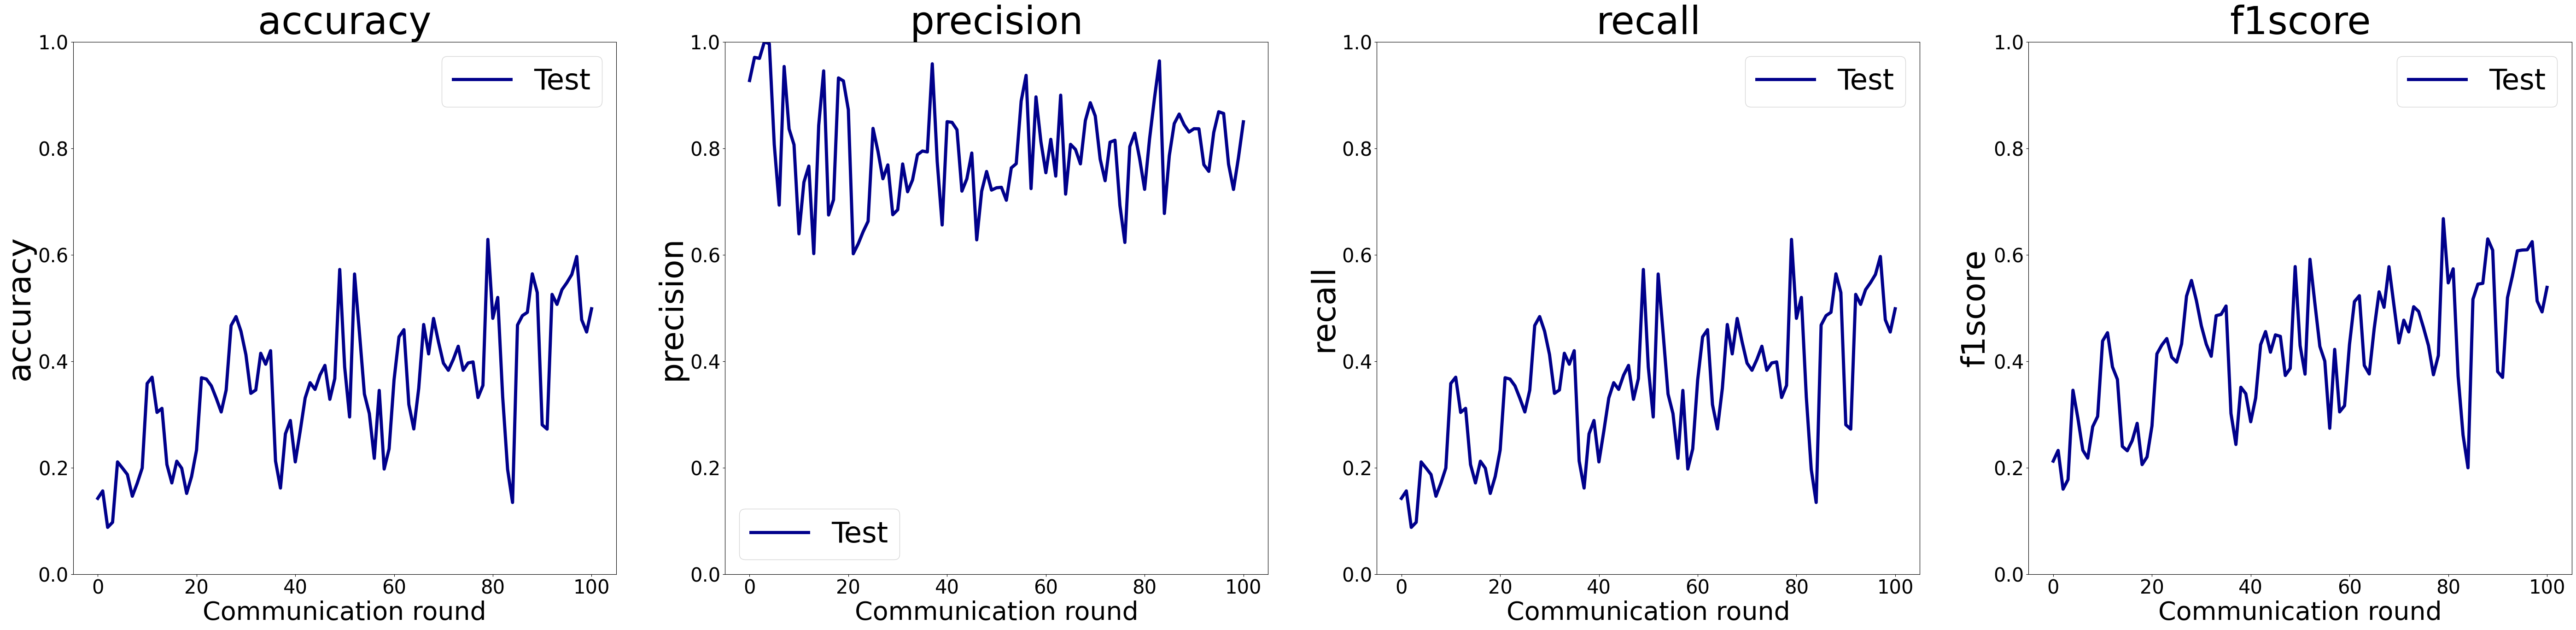

In [15]:
# Define metrics to plot
metrics_show = ["accuracy","precision","recall","f1score"]

# Define dimensions for plot
f, axs = plt.subplots(1,len(metrics_show),figsize=(70,15))

# Loop over the communication round history and metrics
for i in range(len(metrics_show)):
  plt.subplot(1, len(metrics_show), i + 1)
  plot_metric_from_history(commun_metrics_history,"any","centralized",metrics_show[i])